# Walmart Sales Prediction 
## Preview:
This is a challanging yet very fun project with time series data.\
I will explore the usage of Prophet model and lightGBM model on subsets of data based of different methodology of grouping. Then I evaluate them with RMSE and MAPE.\
In Session 1, EDA will be performed to learn about the data sets. Not all results will be posted here. Imputation will be done in this session before building any model.\
In Session 2, Prophet model will be used to all departments for store #18. As you read on, you'll find the result is not ideal with Average RMSE being 9085 and Average MAPE being infinite. I realized that there are enough discrepancies between departments that clustering needs to be done before we talk about performance again.\
In Session 3: K-Means clustering will be used to group data into 3 optimal clusters based on sales volumn. Then lightGBM model will be used on the cluster with highest sales data. In this round, Average RMSE is reduced to 7996.7 and Average MAPE to 8.4%. This result improves Avergage RMSE by 12% only, but MAPE decreases by 100% significantly.\
In Session 4: Adjusted PCA analysis will be performed to identify the weights of different features on 5 principal components. Then Prophet model will be used on one group of departments with one of the PCs. In this round, Average RMSE is reduced to 3566 and Average MAPE to 343%. In this result, Average RMSE decreases by 61% and Average MAPE decreases by 100% as well. It is still not perfect but improvement is still significant.\
In summary, it is very fun experience working on this project. If time permits, I would like to try more models. 


In [112]:
# import sys
# print(sys.executable)
# import sys
# !{sys.executable} -m pip install lightgbm


## Session 1 EDA

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
import os
import time
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb

In [4]:
stores = pd.read_csv('stores.csv')
train_sales = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')

### Merged Data

In [5]:
df_join = train_sales.groupby(["Store","Dept"]).sum(1).reset_index()[["Store","Dept"]].merge(features, on = ["Store"], how="right").merge(train_sales.drop(columns="IsHoliday"), on = ["Store","Dept","Date"], how="left")
df_join

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales
0,1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,24924.50
1,1,2,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,50605.27
2,1,3,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,13740.12
3,1,4,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,39954.04
4,1,5,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,32229.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606237,45,94,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,NaN
606238,45,95,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,NaN
606239,45,96,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,NaN
606240,45,97,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,NaN


In [6]:
# drop date greater than max date in train data
max_date = np.max(train_sales.Date)
print(max_date)
df_join = df_join[df_join["Date"]<=max_date].reset_index(drop=True)
print(df_join.shape)
df_join.head(2)

2012-10-26
(476333, 14)


,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales
0,1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,24924.50
1,1,2,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,50605.27


In [7]:
df_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476333 entries, 0 to 476332
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         476333 non-null  int64  
 1   Dept          476333 non-null  int64  
 2   Date          476333 non-null  object 
 3   Temperature   476333 non-null  float64
 4   Fuel_Price    476333 non-null  float64
 5   MarkDown1     168943 non-null  float64
 6   MarkDown2     123431 non-null  float64
 7   MarkDown3     152700 non-null  float64
 8   MarkDown4     149148 non-null  float64
 9   MarkDown5     169881 non-null  float64
 10  CPI           476333 non-null  float64
 11  Unemployment  476333 non-null  float64
 12  IsHoliday     476333 non-null  bool   
 13  Weekly_Sales  421570 non-null  float64
dtypes: bool(1), float64(10), int64(2), object(1)
memory usage: 47.7+ MB


In [8]:
np.sum(df_join.isnull())

/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Store                0
Dept                 0
Date                 0
Temperature          0
Fuel_Price           0
MarkDown1       307390
MarkDown2       352902
MarkDown3       323633
MarkDown4       327185
MarkDown5       306452
CPI                  0
Unemployment         0
IsHoliday            0
Weekly_Sales     54763
dtype: int64

In [9]:
df_join['Date'] = pd.to_datetime(df_join['Date'])
df_join.info()
# test_df['id'] = test_df['Store'].astype(str) + '_' + test_df['Dept'].astype(str) + '_' + test_df['Date'].astype(str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476333 entries, 0 to 476332
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         476333 non-null  int64         
 1   Dept          476333 non-null  int64         
 2   Date          476333 non-null  datetime64[ns]
 3   Temperature   476333 non-null  float64       
 4   Fuel_Price    476333 non-null  float64       
 5   MarkDown1     168943 non-null  float64       
 6   MarkDown2     123431 non-null  float64       
 7   MarkDown3     152700 non-null  float64       
 8   MarkDown4     149148 non-null  float64       
 9   MarkDown5     169881 non-null  float64       
 10  CPI           476333 non-null  float64       
 11  Unemployment  476333 non-null  float64       
 12  IsHoliday     476333 non-null  bool          
 13  Weekly_Sales  421570 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(10), int64(2)
memory usage: 4

In [10]:
# The plot above is too crowded, try to split the dates and look at yearly trend instead.
df_join['Year'] = df_join['Date'].dt.year
df_join['Month'] = df_join['Date'].dt.month
df_join['Week'] = df_join['Date'].dt.isocalendar().week
df_join['Day of the week'] = df_join['Date'].dt.day_name()
df_join.shape

(476333, 18)

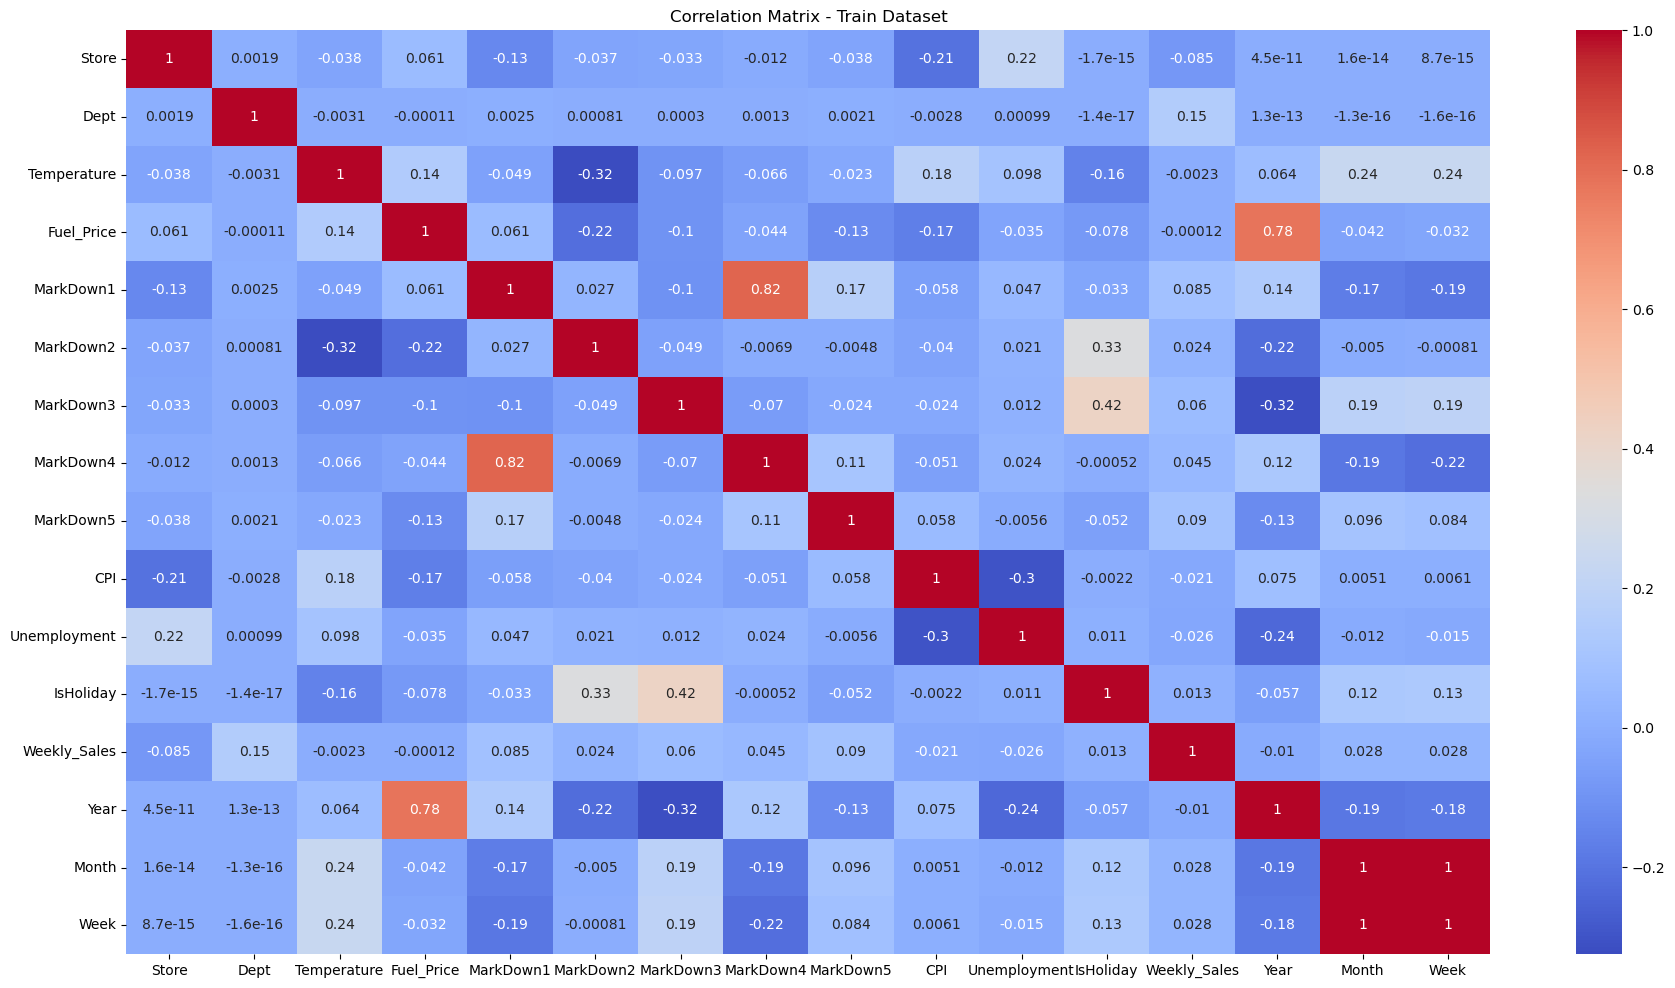

In [11]:
cor_mx= df_join.corr(numeric_only=True)
plt.figure(figsize=(22, 12))
sns.heatmap(cor_mx, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix - Train Dataset')

plt.show()

### Select Store 8 to do more analysis

In [12]:
df_store8 = df_join[(df_join['Store']==8)].reset_index(drop=True)
# df_join["Store"]==45
df_store8.shape

(10868, 18)

### Look at the plots of weekly sales over dates, obviously there are a lot of missing values.

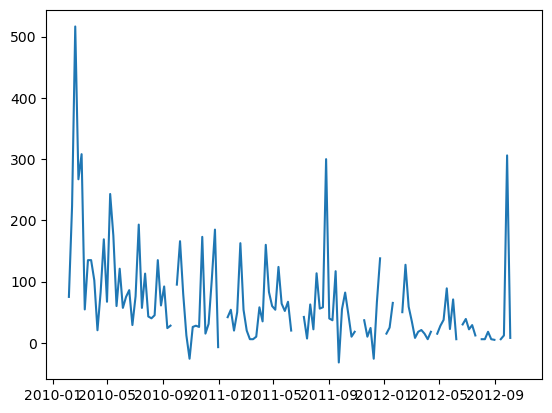

In [13]:

plt.plot(df_store8.loc[df_store8.Dept==54,"Date"], df_store8.loc[df_store8.Dept==54,"Weekly_Sales"])

In [14]:
missing_indices = df_store8.loc[df_store8.Dept==54,"Weekly_Sales"].isnull()
missing_indices

47       False
123      False
199      False
275      False
351      False
         ...  
10535    False
10611    False
10687     True
10763     True
10839    False
Name: Weekly_Sales, Length: 143, dtype: bool

### Imputation

#### 1. Filling missing values with median

In [15]:
df_join_copy1 = df_join.copy()
df_join_copy1.shape

(476333, 18)

In [16]:
df_median = df_join_copy1.groupby(["Store", "Dept"])["Weekly_Sales"].median().reset_index()
df_median.columns = ["Store","Dept","Weekly_Sales_to_fill"]
df_median

,Store,Dept,Weekly_Sales_to_fill
0,1,1,18535.480
1,1,2,45561.850
2,1,3,10366.850
3,1,4,36579.960
4,1,5,21183.420
...,...,...,...
3326,45,94,4120.155
3327,45,95,52417.470
3328,45,96,2.970
3329,45,97,6470.520


In [17]:
df_join_copy1 = df_join_copy1.merge(df_median, on = ["Store", "Dept"])
df_join_copy1.shape

(476333, 19)

In [18]:
df_join_copy1.loc[df_join_copy1["Weekly_Sales"].isnull(),"Weekly_Sales"] = df_join_copy1.loc[df_join_copy1["Weekly_Sales"].isnull(),"Weekly_Sales_to_fill"]

In [19]:
np.sum(df_join_copy1.isnull())

/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Store                        0
Dept                         0
Date                         0
Temperature                  0
Fuel_Price                   0
MarkDown1               307390
MarkDown2               352902
MarkDown3               323633
MarkDown4               327185
MarkDown5               306452
CPI                          0
Unemployment                 0
IsHoliday                    0
Weekly_Sales                 0
Year                         0
Month                        0
Week                         0
Day of the week              0
Weekly_Sales_to_fill         0
dtype: int64

#### After filling out missing values, look at the same plot again

In [20]:
df_store8 = df_join_copy1[(df_join_copy1['Store']==8)]

In [21]:
np.sum(df_store8.isnull())

Store                      0
Dept                       0
Date                       0
Temperature                0
Fuel_Price                 0
MarkDown1               6992
MarkDown2               7676
MarkDown3               7144
MarkDown4               7068
MarkDown5               6992
CPI                        0
Unemployment               0
IsHoliday                  0
Weekly_Sales               0
Year                       0
Month                      0
Week                       0
Day of the week            0
Weekly_Sales_to_fill       0
dtype: int64

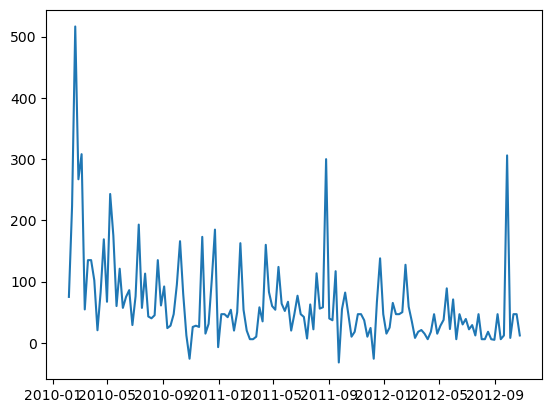

In [22]:
plt.plot(df_store8.loc[df_store8.Dept==54,"Date"], df_store8.loc[df_store8.Dept==54,"Weekly_Sales"])

### 2. Last Observation Carried Forward (LOCF) - Forward Fill missing values
Same method applies if we use backward fill bfill()

In [23]:
df_join_copy2 = df_join.copy()
df_join_copy2

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,Year,Month,Week,Day of the week
0,1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,24924.50,2010,2,5,Friday
1,1,2,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,50605.27,2010,2,5,Friday
2,1,3,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,13740.12,2010,2,5,Friday
3,1,4,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,39954.04,2010,2,5,Friday
4,1,5,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,32229.38,2010,2,5,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476328,45,94,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,5203.31,2012,10,43,Friday
476329,45,95,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,56017.47,2012,10,43,Friday
476330,45,96,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,NaN,2012,10,43,Friday
476331,45,97,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,6817.48,2012,10,43,Friday


In [24]:
# Apply ffill within each group but keep the DataFrame structure intact
df_join_copy2['Weekly_Sales'] = df_join_copy2.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.ffill())

# Now df_join_copy2 contains the original data along with the forward-filled 'Weekly_Sales'
df_join_copy2

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,Year,Month,Week,Day of the week
0,1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,24924.50,2010,2,5,Friday
1,1,2,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,50605.27,2010,2,5,Friday
2,1,3,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,13740.12,2010,2,5,Friday
3,1,4,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,39954.04,2010,2,5,Friday
4,1,5,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,32229.38,2010,2,5,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476328,45,94,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,5203.31,2012,10,43,Friday
476329,45,95,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,56017.47,2012,10,43,Friday
476330,45,96,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,2.94,2012,10,43,Friday
476331,45,97,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,6817.48,2012,10,43,Friday


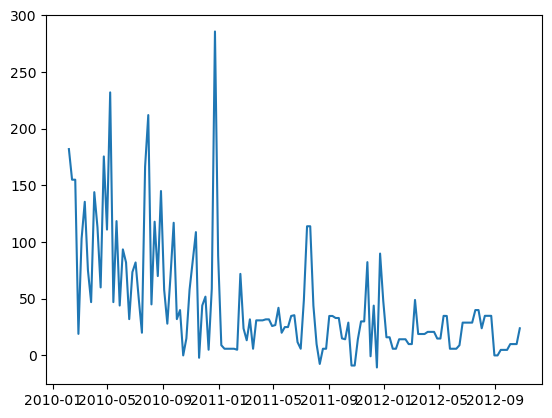

In [25]:
df_store8 = df_join_copy2[(df_join_copy2['Store']==45)]
plt.plot(df_store8.loc[df_store8.Dept==54,"Date"], df_store8.loc[df_store8.Dept==54,"Weekly_Sales"])

## Session 2 Prophet Model
Use the dataset copy with median fill method imputation

In [26]:
import prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [27]:
df_join_copy1 = df_join_copy1.fillna(0)
df_join_copy1.head(2)

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,Year,Month,Week,Day of the week,Weekly_Sales_to_fill
0,1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,24924.50,2010,2,5,Friday,18535.48
1,1,2,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,50605.27,2010,2,5,Friday,45561.85


In [28]:
np.sum(df_join_copy1.isnull())

/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Store                   0
Dept                    0
Date                    0
Temperature             0
Fuel_Price              0
MarkDown1               0
MarkDown2               0
MarkDown3               0
MarkDown4               0
MarkDown5               0
CPI                     0
Unemployment            0
IsHoliday               0
Weekly_Sales            0
Year                    0
Month                   0
Week                    0
Day of the week         0
Weekly_Sales_to_fill    0
dtype: int64

In [29]:
# Find the 105th week
date = list(df_join_copy1["Date"].value_counts().keys())
date.sort()
date[104]

Timestamp('2012-02-03 00:00:00')

#### Further split the training data into subsets

In [30]:
# use 2012-02-03 to 2012-11-01 as test data
train_df = df_join_copy1[df_join_copy1["Date"]<date[104]].reset_index(drop=True)
print(train_df.shape)
train_df.head(2)

(346424, 19)


,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,Year,Month,Week,Day of the week,Weekly_Sales_to_fill
0,1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,24924.50,2010,2,5,Friday,18535.48
1,1,2,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,50605.27,2010,2,5,Friday,45561.85


In [31]:
test_df = df_join_copy1[df_join_copy1["Date"]>=date[104]].reset_index(drop=True)
print(test_df.shape)
test_df.head(2)

(129909, 19)


,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,Year,Month,Week,Day of the week,Weekly_Sales_to_fill
0,1,1,2012-02-03,56.55,3.36,34577.06,3579.21,160.53,32403.87,5630.4,220.172015,7.348,False,23510.49,2012,2,5,Friday,18535.48
1,1,2,2012-02-03,56.55,3.36,34577.06,3579.21,160.53,32403.87,5630.4,220.172015,7.348,False,54322.24,2012,2,5,Friday,45561.85


#### Rename Date and sales columns for modeling purpose. 

In [32]:
train_df.rename(columns={'Date':'ds', 'Weekly_Sales':'y'}, inplace=True)
train_df.head()

,Store,Dept,ds,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,y,Year,Month,Week,Day of the week,Weekly_Sales_to_fill
0,1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,24924.50,2010,2,5,Friday,18535.48
1,1,2,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,50605.27,2010,2,5,Friday,45561.85
2,1,3,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,13740.12,2010,2,5,Friday,10366.85
3,1,4,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,39954.04,2010,2,5,Friday,36579.96
4,1,5,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,32229.38,2010,2,5,Friday,21183.42


In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346424 entries, 0 to 346423
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Store                 346424 non-null  int64         
 1   Dept                  346424 non-null  int64         
 2   ds                    346424 non-null  datetime64[ns]
 3   Temperature           346424 non-null  float64       
 4   Fuel_Price            346424 non-null  float64       
 5   MarkDown1             346424 non-null  float64       
 6   MarkDown2             346424 non-null  float64       
 7   MarkDown3             346424 non-null  float64       
 8   MarkDown4             346424 non-null  float64       
 9   MarkDown5             346424 non-null  float64       
 10  CPI                   346424 non-null  float64       
 11  Unemployment          346424 non-null  float64       
 12  IsHoliday             346424 non-null  bool          
 13 

#### Make holidays more specific

In [34]:
train_df['Holiday_Type'] = None 
    # Apply the conditions
train_df.loc[(train_df['IsHoliday'] == True) & (train_df['ds'].dt.month == 2), 'Holiday_Type'] = 'Super_Bowl'
train_df.loc[(train_df['IsHoliday'] == True) & (train_df['ds'].dt.month == 9), 'Holiday_Type'] = 'Labor_Day'
train_df.loc[(train_df['IsHoliday'] == True) & (train_df['ds'].dt.month == 11), 'Holiday_Type'] = 'Thanksgiving'
train_df.loc[(train_df['IsHoliday'] == True) & (train_df['ds'].dt.month == 12), 'Holiday_Type'] = 'Christmas'
train_df.drop(columns=['IsHoliday'], inplace=True)
    
# 1-hot encoding for categorical features
train_df = pd.get_dummies(train_df, columns=["Holiday_Type"])
columns_to_convert = ['Holiday_Type_Christmas', 'Holiday_Type_Labor_Day', 'Holiday_Type_Super_Bowl', 'Holiday_Type_Thanksgiving']
train_df[columns_to_convert] = train_df[columns_to_convert].astype(int)

    
    # data imputation
train_df.fillna(value=0, inplace=True)
display(train_df.head())

,Store,Dept,ds,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,y,Year,Month,Week,Day of the week,Weekly_Sales_to_fill,Holiday_Type_Christmas,Holiday_Type_Labor_Day,Holiday_Type_Super_Bowl,Holiday_Type_Thanksgiving
0,1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,24924.50,2010,2,5,Friday,18535.48,0,0,0,0
1,1,2,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,50605.27,2010,2,5,Friday,45561.85,0,0,0,0
2,1,3,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,13740.12,2010,2,5,Friday,10366.85,0,0,0,0
3,1,4,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,39954.04,2010,2,5,Friday,36579.96,0,0,0,0
4,1,5,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,32229.38,2010,2,5,Friday,21183.42,0,0,0,0


In [35]:
train_df

,Store,Dept,ds,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,y,Year,Month,Week,Day of the week,Weekly_Sales_to_fill,Holiday_Type_Christmas,Holiday_Type_Labor_Day,Holiday_Type_Super_Bowl,Holiday_Type_Thanksgiving
0,1,1,2010-02-05,42.31,2.572,0.00,0.00,0.0,0.00,0.00,...,24924.50,2010,2,5,Friday,18535.480,0,0,0,0
1,1,2,2010-02-05,42.31,2.572,0.00,0.00,0.0,0.00,0.00,...,50605.27,2010,2,5,Friday,45561.850,0,0,0,0
2,1,3,2010-02-05,42.31,2.572,0.00,0.00,0.0,0.00,0.00,...,13740.12,2010,2,5,Friday,10366.850,0,0,0,0
3,1,4,2010-02-05,42.31,2.572,0.00,0.00,0.0,0.00,0.00,...,39954.04,2010,2,5,Friday,36579.960,0,0,0,0
4,1,5,2010-02-05,42.31,2.572,0.00,0.00,0.0,0.00,0.00,...,32229.38,2010,2,5,Friday,21183.420,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346419,45,94,2012-01-27,37.93,3.567,1890.49,2618.49,0.0,139.07,5692.74,...,3904.32,2012,1,4,Friday,4120.155,0,0,0,0
346420,45,95,2012-01-27,37.93,3.567,1890.49,2618.49,0.0,139.07,5692.74,...,44521.65,2012,1,4,Friday,52417.470,0,0,0,0
346421,45,96,2012-01-27,37.93,3.567,1890.49,2618.49,0.0,139.07,5692.74,...,2.97,2012,1,4,Friday,2.970,0,0,0,0
346422,45,97,2012-01-27,37.93,3.567,1890.49,2618.49,0.0,139.07,5692.74,...,5724.94,2012,1,4,Friday,6470.520,0,0,0,0


In [36]:
holidays = pd.DataFrame({
    'holiday': ['Super_Bowl']*4 + ['Labor_Day']*4 + ['Thanksgiving']*4 + ['Christmas']*4,
    'ds': pd.to_datetime(['02-12-2010', '02-11-2011', '02-10-2012', '02-08-2013',
                          '09-10-2010', '09-09-2011', '09-07-2012', '09-06-2013',
                          '10-26-2010', '10-25-2011', '10-23-2012', '10-29-2013',
                          '12-31-2010', '12-30-2011', '12-28-2012', '12-27-2013',]),
    'lower_window': 0,
    'upper_window': 1,
})

In [37]:
# Select a store to do more analysis.
Store_ID = 18
Models = dict()

for name, group in train_df.groupby(["Store", "Dept"]):
    
    if name[0] != Store_ID:
        continue
        
    data_grouped = group.drop(columns=["Store", "Dept"])
    print(f"\n Training Prophet Model for store={name[0]}, dept={name[1]} with {len(data_grouped)} samples ...")
    if len(data_grouped) < 3:
        print(f"\t\t Number of samples must be larger than 2 !!!")
        Models[name] = [None, np.mean(group['y'])]
        continue
    
    # Creating model
    model = Prophet(
        growth='linear', # linear or logistic
        changepoints=None, # list of dates at which to include potential changepoints
        n_changepoints=11, # number of potential changepoints
        changepoint_range=0.69, # proportion of history in which trend changepoints will be estimated
        yearly_seasonality='auto',
        weekly_seasonality='auto',
        daily_seasonality='auto',
        holidays=holidays,
        seasonality_mode='additive',
        seasonality_prior_scale=6.9,
        holidays_prior_scale=6.9,
        changepoint_prior_scale=0.169,
        mcmc_samples=0, # if > 0: Bayesian inference with number of MCMC samples, else: MAP estimation
        interval_width=0.69, # width of the uncertainty intervals provided for the forecast
        uncertainty_samples=690 # number of simulated draws used to estimate uncertainty intervals
    )

    for col in ['CPI', 'Unemployment']:
        model.add_regressor(name=col, prior_scale=None, standardize='auto', mode='additive')
        
    # Training model        
    t1 = time.time()
    model.fit(data_grouped)
    t2 = time.time()
    print(f"\t\t ... in {round(t2-t1, 3)} seconds")

    Models[name] = [model, np.mean(group['y'])]

11:42:57 - cmdstanpy - INFO - Chain [1] start processing
11:42:57 - cmdstanpy - INFO - Chain [1] done processing
11:42:57 - cmdstanpy - INFO - Chain [1] start processing
11:42:57 - cmdstanpy - INFO - Chain [1] done processing
11:42:57 - cmdstanpy - INFO - Chain [1] start processing



 Training Prophet Model for store=18, dept=1 with 104 samples ...
		 ... in 0.108 seconds

 Training Prophet Model for store=18, dept=2 with 104 samples ...
		 ... in 0.029 seconds

 Training Prophet Model for store=18, dept=3 with 104 samples ...


11:42:57 - cmdstanpy - INFO - Chain [1] done processing
11:42:57 - cmdstanpy - INFO - Chain [1] start processing
11:42:57 - cmdstanpy - INFO - Chain [1] done processing
11:42:57 - cmdstanpy - INFO - Chain [1] start processing
11:42:57 - cmdstanpy - INFO - Chain [1] done processing
11:42:57 - cmdstanpy - INFO - Chain [1] start processing
11:42:57 - cmdstanpy - INFO - Chain [1] done processing
11:42:57 - cmdstanpy - INFO - Chain [1] start processing
11:42:57 - cmdstanpy - INFO - Chain [1] done processing
11:42:57 - cmdstanpy - INFO - Chain [1] start processing
11:42:57 - cmdstanpy - INFO - Chain [1] done processing
11:42:57 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.062 seconds

 Training Prophet Model for store=18, dept=4 with 104 samples ...
		 ... in 0.032 seconds

 Training Prophet Model for store=18, dept=5 with 104 samples ...
		 ... in 0.033 seconds

 Training Prophet Model for store=18, dept=6 with 104 samples ...
		 ... in 0.03 seconds

 Training Prophet Model for store=18, dept=7 with 104 samples ...
		 ... in 0.034 seconds

 Training Prophet Model for store=18, dept=8 with 104 samples ...
		 ... in 0.032 seconds

 Training Prophet Model for store=18, dept=9 with 104 samples ...


11:42:57 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.031 seconds

 Training Prophet Model for store=18, dept=10 with 104 samples ...
		 ... in 0.031 seconds

 Training Prophet Model for store=18, dept=11 with 104 samples ...
		 ... in 0.032 seconds

 Training Prophet Model for store=18, dept=12 with 104 samples ...
		 ... in 0.033 seconds

 Training Prophet Model for store=18, dept=13 with 104 samples ...
		 ... in 0.032 seconds

 Training Prophet Model for store=18, dept=14 with 104 samples ...
		 ... in 0.029 seconds

 Training Prophet Model for store=18, dept=16 with 104 samples ...
		 ... in 0.031 seconds


11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing



 Training Prophet Model for store=18, dept=17 with 104 samples ...
		 ... in 0.031 seconds

 Training Prophet Model for store=18, dept=18 with 104 samples ...
		 ... in 0.031 seconds

 Training Prophet Model for store=18, dept=19 with 104 samples ...
		 ... in 0.03 seconds

 Training Prophet Model for store=18, dept=20 with 104 samples ...
		 ... in 0.03 seconds

 Training Prophet Model for store=18, dept=21 with 104 samples ...
		 ... in 0.033 seconds

 Training Prophet Model for store=18, dept=22 with 104 samples ...
		 ... in 0.031 seconds


11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:42:58 - cmdstanpy - INFO - Chain [1] start processing



 Training Prophet Model for store=18, dept=23 with 104 samples ...
		 ... in 0.036 seconds

 Training Prophet Model for store=18, dept=24 with 104 samples ...
		 ... in 0.029 seconds

 Training Prophet Model for store=18, dept=25 with 104 samples ...
		 ... in 0.03 seconds

 Training Prophet Model for store=18, dept=26 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=27 with 104 samples ...


11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.141 seconds

 Training Prophet Model for store=18, dept=28 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=29 with 104 samples ...
		 ... in 0.027 seconds

 Training Prophet Model for store=18, dept=30 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=31 with 104 samples ...
		 ... in 0.027 seconds

 Training Prophet Model for store=18, dept=32 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=33 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=34 with 104 samples ...


11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=35 with 104 samples ...
		 ... in 0.029 seconds

 Training Prophet Model for store=18, dept=36 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=38 with 104 samples ...
		 ... in 0.027 seconds

 Training Prophet Model for store=18, dept=39 with 104 samples ...
		 ... in 0.009 seconds

 Training Prophet Model for store=18, dept=40 with 104 samples ...
		 ... in 0.026 seconds

 Training Prophet Model for store=18, dept=41 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=42 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=44 with 104 samples ...


11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=45 with 104 samples ...
		 ... in 0.029 seconds

 Training Prophet Model for store=18, dept=46 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=47 with 104 samples ...
		 ... in 0.026 seconds

 Training Prophet Model for store=18, dept=48 with 104 samples ...
		 ... in 0.009 seconds

 Training Prophet Model for store=18, dept=49 with 104 samples ...
		 ... in 0.027 seconds

 Training Prophet Model for store=18, dept=50 with 104 samples ...
		 ... in 0.026 seconds

 Training Prophet Model for store=18, dept=51 with 104 samples ...
		 ... in 0.027 seconds

 Training Prophet Model for store=18, dept=52 with 104 samples ...


11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=54 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=55 with 104 samples ...
		 ... in 0.033 seconds

 Training Prophet Model for store=18, dept=56 with 104 samples ...
		 ... in 0.029 seconds

 Training Prophet Model for store=18, dept=58 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=59 with 104 samples ...
		 ... in 0.029 seconds

 Training Prophet Model for store=18, dept=60 with 104 samples ...
		 ... in 0.032 seconds

 Training Prophet Model for store=18, dept=67 with 104 samples ...


11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.029 seconds

 Training Prophet Model for store=18, dept=71 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=72 with 104 samples ...
		 ... in 0.029 seconds

 Training Prophet Model for store=18, dept=74 with 104 samples ...
		 ... in 0.027 seconds

 Training Prophet Model for store=18, dept=77 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=18, dept=78 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=79 with 104 samples ...
		 ... in 0.029 seconds

 Training Prophet Model for store=18, dept=80 with 104 samples ...


11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=81 with 104 samples ...
		 ... in 0.027 seconds

 Training Prophet Model for store=18, dept=82 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=83 with 104 samples ...
		 ... in 0.031 seconds

 Training Prophet Model for store=18, dept=85 with 104 samples ...
		 ... in 0.032 seconds

 Training Prophet Model for store=18, dept=87 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=90 with 104 samples ...
		 ... in 0.029 seconds

 Training Prophet Model for store=18, dept=91 with 104 samples ...


11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:42:59 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:43:00 - cmdstanpy - INFO - Chain [1] start processing
11:43:00 - cmdstanpy - INFO - Chain [1] done processing
11:43:00 - cmdstanpy - INFO - Chain [1] start processing
11:43:00 - cmdstanpy - INFO - Chain [1] done processing
11:43:00 - cmdstanpy - INFO - Chain [1] start processing
11:43:00 - cmdstanpy - INFO - Chain [1] done processing
11:43:00 - cmdstanpy - INFO - Chain [1] start processing
11:43:00 - cmdstanpy - INFO - Chain [1] done processing
11:43:00 - cmdstanpy - INFO - Chain [1] start processing
11:43:00 - cmdstanpy - INFO - Chain [1] done processing
11:43:00 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.031 seconds

 Training Prophet Model for store=18, dept=92 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=93 with 104 samples ...
		 ... in 0.03 seconds

 Training Prophet Model for store=18, dept=94 with 104 samples ...
		 ... in 0.027 seconds

 Training Prophet Model for store=18, dept=95 with 104 samples ...
		 ... in 0.029 seconds

 Training Prophet Model for store=18, dept=96 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=97 with 104 samples ...
		 ... in 0.029 seconds

 Training Prophet Model for store=18, dept=98 with 104 samples ...


11:43:00 - cmdstanpy - INFO - Chain [1] done processing
11:43:00 - cmdstanpy - INFO - Chain [1] start processing
11:43:00 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.028 seconds

 Training Prophet Model for store=18, dept=99 with 104 samples ...
		 ... in 0.031 seconds


In [38]:
test_df.rename(columns={'Date': 'ds', 'Weekly_Sales':'y'}, inplace=True)
for col in train_df.columns:
    if col in ['ds', 'y']:
        continue
    if col not in list(test_df.columns):
        test_df[col] = 0

result = []
for name, group in test_df.groupby(["Store", "Dept"]):

    if name[0] != Store_ID:
        continue
        
    data_grouped = group.drop(columns=["Store", "Dept"])
    print(f"\n Predicting Prophet Model for store={name[0]}, dept={name[1]} with {len(data_grouped)} samples ...")
    if name not in list(Models.keys()):
        forecast = group.copy()
        forecast['yhat'] = np.mean(data_train.y)
    else:
        model, mean_value = Models[name]
        if model is None:
            forecast = group.copy()
            forecast['yhat'] = mean_value
        else:
            try:
                t1 = time.time()
                forecast = model.predict(df=data_grouped)
                t2 = time.time()
                print(f"\t ... in {round(t2-t1, 3)} seconds")
                forecast["Store"] = name[0]
                forecast["Dept"] = name[1]
            except Exception as e:
                print(e)
                forecast = group.copy()
                forecast['yhat'] = mean_value
            
    # 1st-date: Friday, 05-02-2010
    # Models[name].plot_components(forecast, weekly_start=5, yearly_start=31+5)
    forecast['yhat'][forecast['yhat']<0] = 20
    result.append(forecast[['Store', 'Dept', 'ds', 'yhat']])

/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/3081378533.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/30813


 Predicting Prophet Model for store=18, dept=1 with 39 samples ...
	 ... in 0.024 seconds

 Predicting Prophet Model for store=18, dept=2 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=3 with 39 samples ...
	 ... in 0.023 seconds

 Predicting Prophet Model for store=18, dept=4 with 39 samples ...
	 ... in 0.023 seconds

 Predicting Prophet Model for store=18, dept=5 with 39 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/3081378533.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/30813

	 ... in 0.022 seconds

 Predicting Prophet Model for store=18, dept=6 with 39 samples ...
	 ... in 0.024 seconds

 Predicting Prophet Model for store=18, dept=7 with 39 samples ...
	 ... in 0.023 seconds

 Predicting Prophet Model for store=18, dept=8 with 39 samples ...
	 ... in 0.022 seconds

 Predicting Prophet Model for store=18, dept=9 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=10 with 39 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/3081378533.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/30813

	 ... in 0.022 seconds

 Predicting Prophet Model for store=18, dept=11 with 39 samples ...
	 ... in 0.024 seconds

 Predicting Prophet Model for store=18, dept=12 with 39 samples ...
	 ... in 0.023 seconds

 Predicting Prophet Model for store=18, dept=13 with 39 samples ...
	 ... in 0.024 seconds

 Predicting Prophet Model for store=18, dept=14 with 39 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/3081378533.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/30813

	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=16 with 39 samples ...
	 ... in 0.024 seconds

 Predicting Prophet Model for store=18, dept=17 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=18 with 39 samples ...
	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=19 with 39 samples ...
	 ... in 0.019 seconds

 Predicting Prophet Model for store=18, dept=20 with 39 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/3081378533.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/30813

	 ... in 0.065 seconds

 Predicting Prophet Model for store=18, dept=21 with 39 samples ...
	 ... in 0.022 seconds

 Predicting Prophet Model for store=18, dept=22 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=23 with 39 samples ...
	 ... in 0.019 seconds


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/3081378533.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/30813


 Predicting Prophet Model for store=18, dept=24 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=25 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=26 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=27 with 39 samples ...
	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=28 with 39 samples ...
	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=29 with 39 samples ...
	 ... in 0.019 seconds

 Predicting Prophet Model for store=18, dept=30 with 39 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/3081378533.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/30813

	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=31 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=32 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=33 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=34 with 39 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/3081378533.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/30813

	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=35 with 39 samples ...
	 ... in 0.022 seconds

 Predicting Prophet Model for store=18, dept=36 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=38 with 39 samples ...
	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=39 with 39 samples ...
	 ... in 0.019 seconds

 Predicting Prophet Model for store=18, dept=40 with 39 samples ...
	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=41 with 39 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/3081378533.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/30813

	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=42 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=44 with 39 samples ...
	 ... in 0.019 seconds

 Predicting Prophet Model for store=18, dept=45 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=46 with 39 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/3081378533.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/30813

	 ... in 0.022 seconds

 Predicting Prophet Model for store=18, dept=47 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=48 with 39 samples ...
	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=49 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=50 with 39 samples ...
	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=51 with 39 samples ...
	 ... in 0.019 seconds

 Predicting Prophet Model for store=18, dept=52 with 39 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/3081378533.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/30813

	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=54 with 39 samples ...
	 ... in 0.022 seconds

 Predicting Prophet Model for store=18, dept=55 with 39 samples ...
	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=56 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=58 with 39 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/3081378533.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/30813

	 ... in 0.022 seconds

 Predicting Prophet Model for store=18, dept=59 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=60 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=67 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=71 with 39 samples ...
	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=72 with 39 samples ...
	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=74 with 39 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/3081378533.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/30813

	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=77 with 39 samples ...
	 ... in 0.022 seconds

 Predicting Prophet Model for store=18, dept=78 with 39 samples ...
	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=79 with 39 samples ...
	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=80 with 39 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/3081378533.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/30813

	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=81 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=82 with 39 samples ...
	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=83 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=85 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=87 with 39 samples ...
	 ... in 0.019 seconds

 Predicting Prophet Model for store=18, dept=90 with 39 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/3081378533.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/30813

	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=91 with 39 samples ...
	 ... in 0.021 seconds

 Predicting Prophet Model for store=18, dept=92 with 39 samples ...
	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=93 with 39 samples ...
	 ... in 0.019 seconds

 Predicting Prophet Model for store=18, dept=94 with 39 samples ...
	 ... in 0.019 seconds

 Predicting Prophet Model for store=18, dept=95 with 39 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/3081378533.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/30813

	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=96 with 39 samples ...
	 ... in 0.022 seconds

 Predicting Prophet Model for store=18, dept=97 with 39 samples ...
	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=98 with 39 samples ...
	 ... in 0.02 seconds

 Predicting Prophet Model for store=18, dept=99 with 39 samples ...
	 ... in 0.021 seconds


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/3081378533.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/30813

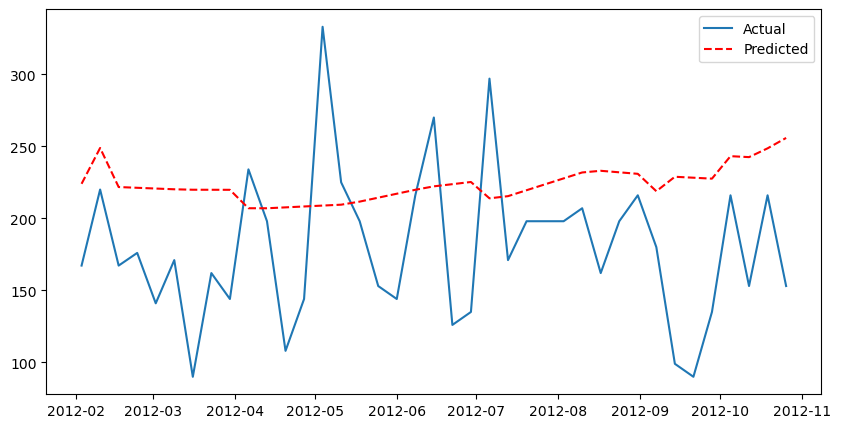

In [39]:
# Example for a specific store and department
all_forecasts = pd.concat(result)
test_forecast = all_forecasts[(all_forecasts['Store'] == 18) & (all_forecasts['Dept'] == 60)]
test_dataframe = test_df[(test_df['Store'] == 18) & (test_df['Dept'] == 60)]
plt.figure(figsize=(10, 5))
plt.plot(test_dataframe['ds'], test_dataframe['y'], label='Actual')
plt.plot(test_forecast['ds'], test_forecast['yhat'], linestyle='--', color='red', label='Predicted')
plt.legend()
plt.show()


#### Looking at the plot for a single store and a single department, the model result is not ideal. Therefore, 
#### let's try to use RMSE and MAPE to evaluate model performance on a wider scale. 

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MSE and MAPE
rmse_values = []
mape_values = []

for name, group in test_df.groupby(['Store', 'Dept']):
    if name not in Models:
        continue
    actual = group['y']
    predicted = all_forecasts.loc[(all_forecasts['Store'] == name[0]) & (all_forecasts['Dept'] == name[1]), 'yhat']
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted)
    rmse_values.append(rmse)
    mape_values.append(mape)
    print(f"Store {name[0]}, Dept {name[1]}: RMSE = {rmse}, MAPE = {mape}%")

average_rmse = np.mean(rmse_values)
average_mape = np.mean(mape_values)
print(f'Average RMSE: {average_rmse}')
print(f'Average MAPE: {average_mape}%')


Store 18, Dept 1: RMSE = 11729.110333990833, MAPE = 42.25426485729784%
Store 18, Dept 2: RMSE = 14025.75557521515, MAPE = 19.58036440679928%
Store 18, Dept 3: RMSE = 14676.586778981162, MAPE = 82.31825753358125%
Store 18, Dept 4: RMSE = 1965.1665537989252, MAPE = 6.157293957747986%
Store 18, Dept 5: RMSE = 46358.74697448503, MAPE = 259.72807040679277%
Store 18, Dept 6: RMSE = 4485.180441205422, MAPE = 124.2971992064627%
Store 18, Dept 7: RMSE = 116886.98476753566, MAPE = 418.66773956196994%
Store 18, Dept 8: RMSE = 4615.091625879531, MAPE = 13.521281011540795%
Store 18, Dept 9: RMSE = 6602.29548085859, MAPE = 27.321700253899333%
Store 18, Dept 10: RMSE = 1886.9863452930715, MAPE = 11.023394886588424%
Store 18, Dept 11: RMSE = 10726.537218316653, MAPE = 26.820483262358696%
Store 18, Dept 12: RMSE = 2208.1073917285335, MAPE = 52.65206461980091%
Store 18, Dept 13: RMSE = 6603.617979216559, MAPE = 12.119694330971157%
Store 18, Dept 14: RMSE = 18117.200113378585, MAPE = 84.62401158735145%
S

/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/1951640745.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


## KMeans Clustering
#### According to the Prophet model, there are big discrepancies between different departments. So we should try to group departments into different clusters and apply models again. 
#### According to the elbow plot, the optimal cluster number is 3. Since the data is high-dimentional, we should try to reduce dimensions by PCA. 

#### Use sales as the only feature to cluster.

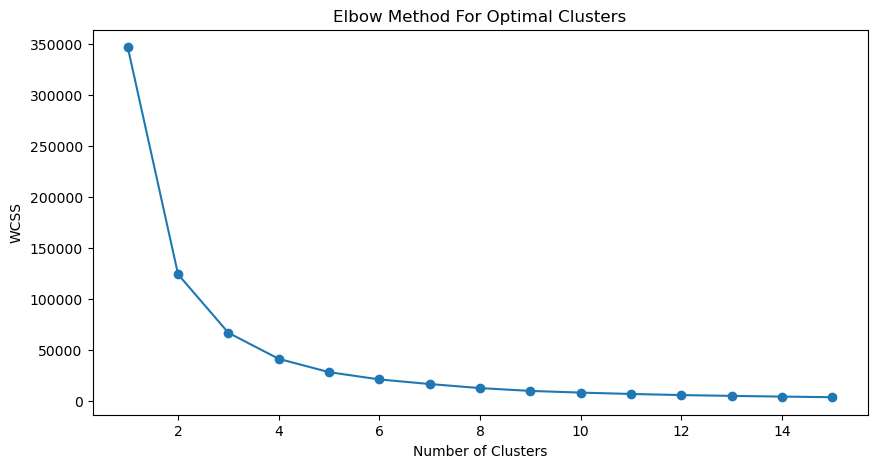

In [41]:
cluster_features = train_df[['y']]

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(cluster_features)

# Calculate the within-cluster sum of squares for different cluster counts
ks = range(1,16)
WCSS = [KMeans(n_clusters=k, n_init=10).fit(features_scaled).inertia_ for k in ks]


# Plot the elbow graph
plt.figure(figsize=(10, 5))
plt.plot(ks, WCSS, marker='o')
plt.title('Elbow Method For Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')  # Within-cluster sum of squares
plt.show()

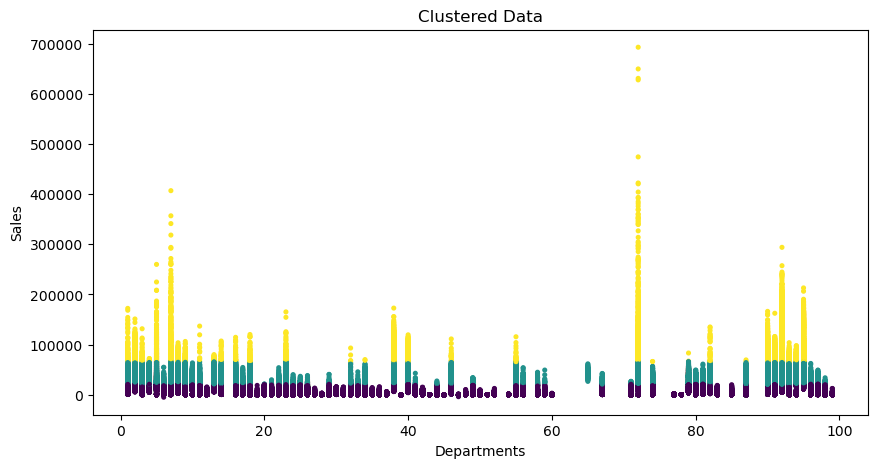

In [42]:
clustering = KMeans(n_clusters=3, n_init=100)
clustering.fit(train_df[['Dept','y']])
train_df['Cluster'] = clustering.labels_

#Plot the elbow graph
plt.figure(figsize=(10, 5))
plt.scatter(train_df['Dept'],train_df['y'],c=clustering.labels_, s=7)
plt.title('Clustered Data')
plt.xlabel('Departments')
plt.ylabel('Sales')
plt.show()

In [43]:
train_df.columns

Index(['Store', 'Dept', 'ds', 'Temperature', 'Fuel_Price', 'MarkDown1',
       'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'y', 'Year', 'Month', 'Week', 'Day of the week',
       'Weekly_Sales_to_fill', 'Holiday_Type_Christmas',
       'Holiday_Type_Labor_Day', 'Holiday_Type_Super_Bowl',
       'Holiday_Type_Thanksgiving', 'Cluster'],
      dtype='object')

## Build a LightGBM model to train departments in Cluster 2 with the highest sales data

Prepare for the data and features

In [44]:
train_df_gbm = train_df.copy().merge(stores)

In [45]:
train_df_gbm.shape

(346424, 25)

In [46]:
train_df_gbm.head()

,Store,Dept,ds,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Week,Day of the week,Weekly_Sales_to_fill,Holiday_Type_Christmas,Holiday_Type_Labor_Day,Holiday_Type_Super_Bowl,Holiday_Type_Thanksgiving,Cluster,Type,Size
0,1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,5,Friday,18535.48,0,0,0,0,1,A,151315
1,1,2,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,5,Friday,45561.85,0,0,0,0,1,A,151315
2,1,3,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,5,Friday,10366.85,0,0,0,0,0,A,151315
3,1,4,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,5,Friday,36579.96,0,0,0,0,1,A,151315
4,1,5,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,5,Friday,21183.42,0,0,0,0,1,A,151315


Onehot encoding

In [47]:
# One-hot encode the type feature
encoder = OneHotEncoder(sparse_output=False, drop="first")
encoded = encoder.fit_transform(train_df_gbm[['Type']])
encoded_df = pd.DataFrame(encoded, index=train_df_gbm.index, columns=[f'type_{i+1}' for i in range(encoded.shape[1])])

# Join the encoded features with the original dataframe
df_gbm = pd.concat([train_df_gbm, encoded_df], axis=1)
df_gbm.head(1)

,Store,Dept,ds,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Weekly_Sales_to_fill,Holiday_Type_Christmas,Holiday_Type_Labor_Day,Holiday_Type_Super_Bowl,Holiday_Type_Thanksgiving,Cluster,Type,Size,type_1,type_2
0,1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,18535.48,0,0,0,0,1,A,151315,0.0,0.0


In [48]:
# convert previous 5 sales to features
df_gbm = df_gbm.sort_values(['Store','Dept','ds']).reset_index(drop=True)
for i in range(1,6):
    df_gbm[f'lag_{i}'] = df_gbm.groupby(['Store','Dept'])['y'].shift(i)
df_gbm.head(6)

,Store,Dept,ds,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Cluster,Type,Size,type_1,type_2,lag_1,lag_2,lag_3,lag_4,lag_5
0,1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,1,A,151315,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1,1,2010-02-12,38.51,2.548,0.0,0.0,0.0,0.0,0.0,...,1,A,151315,0.0,0.0,24924.50,NaN,NaN,NaN,NaN
2,1,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,...,1,A,151315,0.0,0.0,46039.49,24924.50,NaN,NaN,NaN
3,1,1,2010-02-26,46.63,2.561,0.0,0.0,0.0,0.0,0.0,...,0,A,151315,0.0,0.0,41595.55,46039.49,24924.50,NaN,NaN
4,1,1,2010-03-05,46.50,2.625,0.0,0.0,0.0,0.0,0.0,...,1,A,151315,0.0,0.0,19403.54,41595.55,46039.49,24924.50,NaN
5,1,1,2010-03-12,57.79,2.667,0.0,0.0,0.0,0.0,0.0,...,1,A,151315,0.0,0.0,21827.90,19403.54,41595.55,46039.49,24924.5


Remove first 5 rows with NAs.

In [49]:
df_gbm.dropna(inplace=True)

In [50]:
df_gbm.head()

,Store,Dept,ds,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Cluster,Type,Size,type_1,type_2,lag_1,lag_2,lag_3,lag_4,lag_5
5,1,1,2010-03-12,57.79,2.667,0.0,0.0,0.0,0.0,0.0,...,1,A,151315,0.0,0.0,21827.90,19403.54,41595.55,46039.49,24924.50
6,1,1,2010-03-19,54.58,2.720,0.0,0.0,0.0,0.0,0.0,...,1,A,151315,0.0,0.0,21043.39,21827.90,19403.54,41595.55,46039.49
7,1,1,2010-03-26,51.45,2.732,0.0,0.0,0.0,0.0,0.0,...,1,A,151315,0.0,0.0,22136.64,21043.39,21827.90,19403.54,41595.55
8,1,1,2010-04-02,62.27,2.719,0.0,0.0,0.0,0.0,0.0,...,1,A,151315,0.0,0.0,26229.21,22136.64,21043.39,21827.90,19403.54
9,1,1,2010-04-09,65.86,2.770,0.0,0.0,0.0,0.0,0.0,...,1,A,151315,0.0,0.0,57258.43,26229.21,22136.64,21043.39,21827.90


In [106]:
# Subset data by cluster before spliting
df_gbm_c2 = df_gbm[df_gbm['Cluster']==2]

In [58]:
check_sales = df_gbm_c2.y
check_sales

458        70158.86
462        85676.09
510        79340.15
666        72635.06
669        96198.12
            ...    
344438    198041.11
344442    116924.78
345118     67985.32
346078     66287.00
346089     75204.77
Name: y, Length: 12304, dtype: float64

In [52]:
# train and test split
date_to_split = df_gbm_c2.ds.unique()[-5]
train_gbm = df_gbm_c2[df_gbm_c2.ds<date_to_split].reset_index(drop=True)
test_gbm = df_gbm_c2[df_gbm_c2.ds>=date_to_split].reset_index(drop=True)

In [53]:
date_to_split

Timestamp('2012-01-20 00:00:00')

In [54]:
# Prepare datasets for LightGBM
features = ['Temperature', 'Fuel_Price', 'MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
            'Unemployment', 'Holiday_Type_Christmas', 'Holiday_Type_Labor_Day', 'Holiday_Type_Super_Bowl',
            'Holiday_Type_Thanksgiving','Year', 'Month', 'Week', 'Size', 'type_1', 'type_2', 'lag_1',
            'lag_2', 'lag_3', 'lag_4', 'lag_5']
X_train, y_train = train_gbm[features], train_gbm['y']
X_test, y_test = test_gbm[features], test_gbm['y']

In [55]:
# Configure and train the LightGBM model for Cluster 1 departments
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 10,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 5
}
train_data = lgb.Dataset(X_train, label=y_train)
gbm = lgb.train(params, train_data, num_boost_round=200)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3549
[LightGBM] [Info] Number of data points in the train set: 12091, number of used features: 24
[LightGBM] [Info] Start training from score 95178.450836


In [56]:
y_pred = gbm.predict(X_test)
test_gbm['y_pred'] = y_pred

97 2


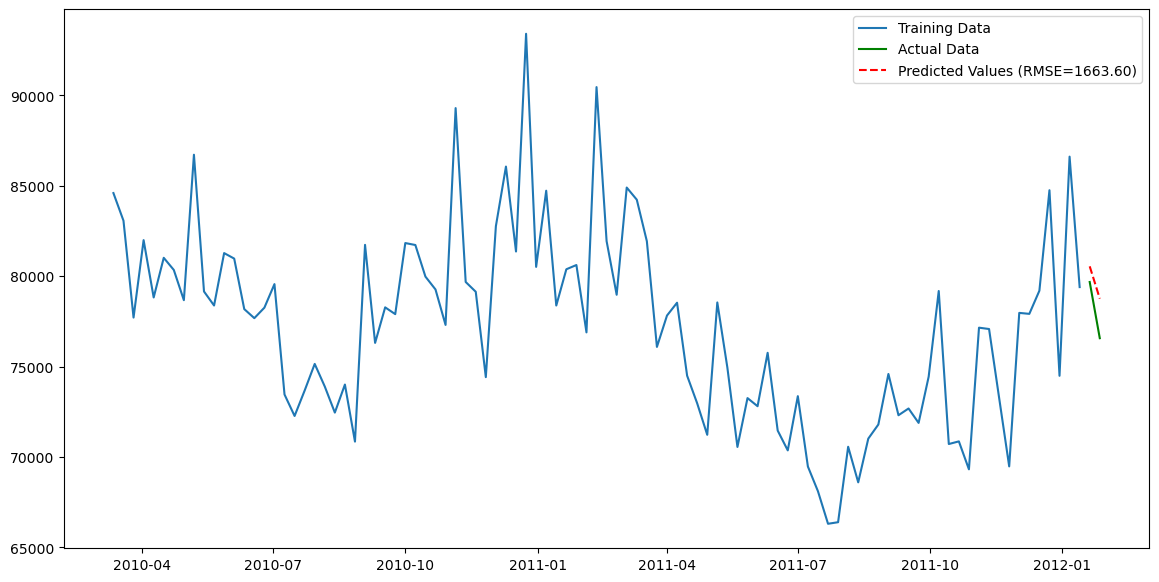

In [83]:
# Plot Store 25 Dept 83
plot_train = train_gbm[(train_gbm["Store"]==2)&(train_gbm["Dept"]==40)]
plot_test = test_gbm[(test_gbm["Store"]==2)&(test_gbm["Dept"]==40)]
rmse = np.sqrt(mean_squared_error(plot_test.y, plot_test.y_pred))
print(plot_train.shape[0],plot_test.shape[0])

plt.figure(figsize = (14,7))
plt.plot(plot_train.ds, plot_train.y, label="Training Data")
plt.plot(plot_test.ds, plot_test.y, label="Actual Data", color='green')
plt.plot(plot_test.ds, plot_test.y_pred,label='Predicted Values (RMSE={:0.2f})'.format(rmse), linestyle='--', color='red')
plt.legend()
plt.show()

96 2


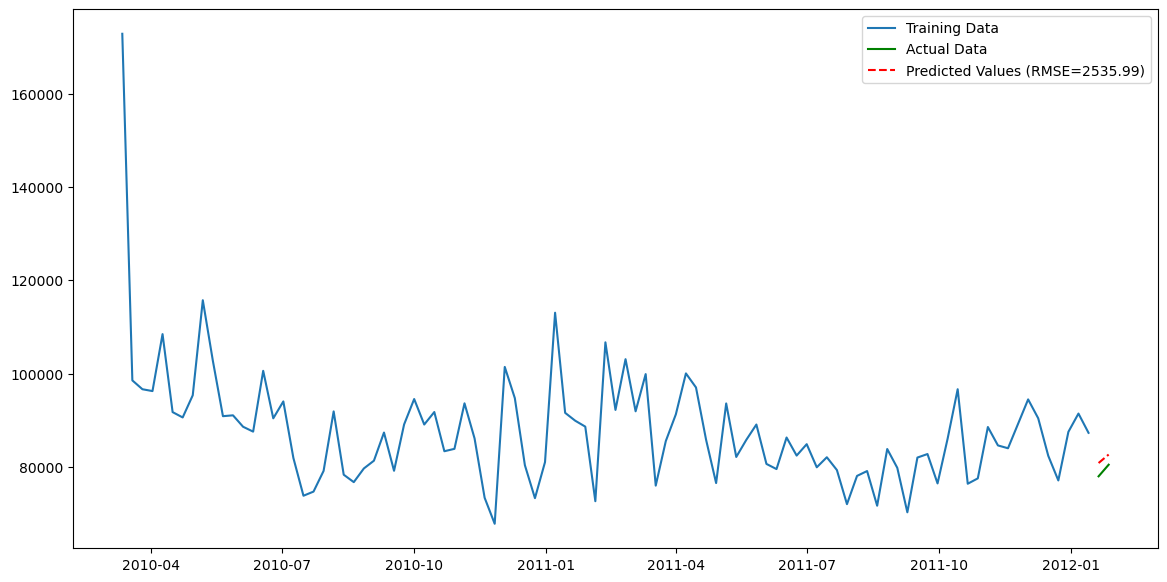

In [105]:
# Plot Store 2 Dept 38
plot_train = train_gbm[(train_gbm["Store"]==2)&(train_gbm["Dept"]==38)]
plot_test = test_gbm[(test_gbm["Store"]==2)&(test_gbm["Dept"]==38)]
rmse = np.sqrt(mean_squared_error(plot_test.y, plot_test.y_pred))
print(plot_train.shape[0],plot_test.shape[0])

plt.figure(figsize = (14,7))
plt.plot(plot_train.ds, plot_train.y, label="Training Data")
plt.plot(plot_test.ds, plot_test.y, label="Actual Data", color='green')
plt.plot(plot_test.ds, plot_test.y_pred,label='Predicted Values (RMSE={:0.2f})'.format(rmse), linestyle='--', color='red')
plt.legend()
plt.show()

In [110]:
# Calculate MSE and MAPE
rmse_values = []
mape_values = []

for name, group in test_gbm.groupby(['Store', 'Dept']):

    actual = group['y']
    predicted = group['y_pred']
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted)
    rmse_values.append(rmse)
    mape_values.append(mape)
    print(f"Store {name[0]}, Dept {name[1]}: RMSE = {rmse}, MAPE = {mape}%")

average_rmse = np.mean(rmse_values)
average_mape = np.mean(mape_values)
print(f'Average RMSE: {average_rmse}')
print(f'Average MAPE: {average_mape}%')


Store 1, Dept 38: RMSE = 6428.162692877478, MAPE = 8.41584803281663%
Store 1, Dept 90: RMSE = 9842.198216837129, MAPE = 8.709330225457744%
Store 1, Dept 92: RMSE = 19954.992324697552, MAPE = 12.936095916595425%
Store 1, Dept 93: RMSE = 11158.53536243143, MAPE = 15.180714156474707%
Store 1, Dept 95: RMSE = 5635.402638028826, MAPE = 5.153296689221892%
Store 2, Dept 38: RMSE = 2535.9863612519894, MAPE = 3.1793432090072633%
Store 2, Dept 40: RMSE = 1663.6003971019734, MAPE = 1.9721126034579892%
Store 2, Dept 72: RMSE = 11623.888108458836, MAPE = 17.011061699291517%
Store 2, Dept 90: RMSE = 12187.195381898171, MAPE = 9.605326370800183%
Store 2, Dept 91: RMSE = 4088.093404551579, MAPE = 5.1606264083961655%
Store 2, Dept 92: RMSE = 16587.910250760076, MAPE = 7.0680858481120685%
Store 2, Dept 93: RMSE = 14752.323806963162, MAPE = 20.92601811661341%
Store 2, Dept 94: RMSE = 4344.473946109065, MAPE = 6.508348992378189%
Store 2, Dept 95: RMSE = 8494.738239443599, MAPE = 5.884092988701018%
Store 3

## Session 4 PCA Analysis
Since results from lightGBM model and k-Means clustering are not ideal. I'll try to adjust PCA analysis to incorporate more features.\
First, define PCA numbers to be 5 and fit scaled features to PCA. \
Second, plot PCA loadings, to explore the weights of different features on each PC.\
From the heatmap, we separate the significance of different features on PC1 to PC5. \
PC1: Unemployment and Fuel_Price have strong influences on departments in this group, CPI has negative influence. \
PC2: Temperature and CPI have strong negative correlation on departments in this group. and \
PC3: Super Bowl has strong influence on this group. \
PC4: Thanksgiving has strong influence on this group

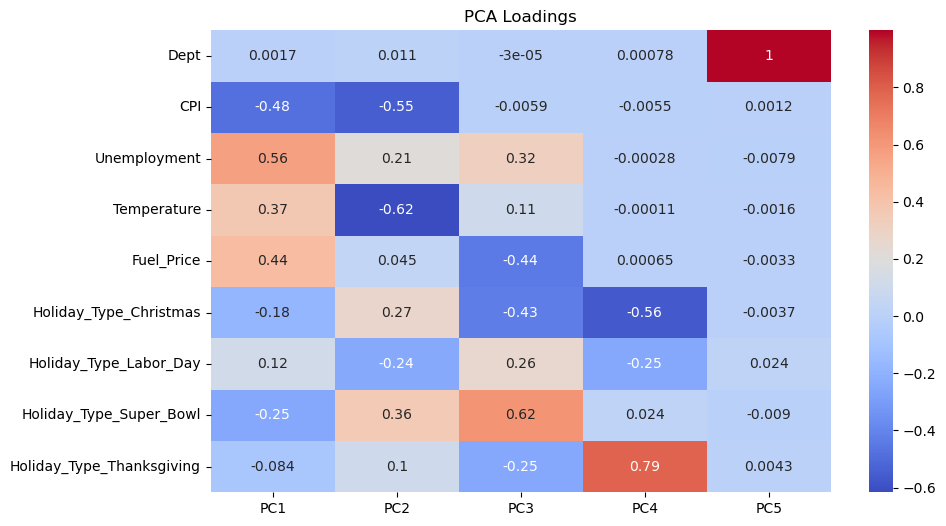

In [85]:

# List of original features used for PCA
features_list = ['Dept', 'CPI', 'Unemployment', 'Temperature', 'Fuel_Price','Holiday_Type_Christmas',
                  'Holiday_Type_Labor_Day', 'Holiday_Type_Super_Bowl','Holiday_Type_Thanksgiving']
features_scaled = scaler.fit_transform(train_df[features_list])

pca = PCA(n_components=5)
principal_components = pca.fit_transform(features_scaled)

# Create a DataFrame of the PCA loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=features_list)

# Plot the loadings
plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm')
plt.title('PCA Loadings')
plt.show()

#### Continue to group departments by PC. 

In [86]:
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

# Adding department labels
principal_df['Dept'] = train_df['Dept']

# Function to get top departments for each PC
def top_departments(pc, num_top=10):
    # Group by 'Dept', average the PC scores, and sort them
    return (principal_df.groupby('Dept')[pc]
            .mean()
            .sort_values(ascending=False)
            .head(num_top)
            .reset_index())

# Now Group departments by PC.
top_departments_by_pc1 = top_departments('PC1')
top_departments_by_pc2 = top_departments('PC2')
top_departments_by_pc3 = top_departments('PC3')
top_departments_by_pc4 = top_departments('PC4')
top_departments_by_pc5 = top_departments('PC5')

print(top_departments_by_pc1)
print(top_departments_by_pc2)
print(top_departments_by_pc3)
print(top_departments_by_pc4)
print(top_departments_by_pc5)

   Dept       PC1
0    65  0.933769
1    43  0.810119
2    39  0.174860
3    83  0.064673
4    93  0.055855
5    99  0.042279
6    50  0.024175
7    27  0.021569
8    35  0.017985
9    34  0.017911
   Dept       PC2
0    65  0.868260
1    43  0.654795
2    39  0.310981
3    50  0.234266
4    48  0.100243
5    99  0.079081
6    58  0.068481
7    93  0.059682
8    83  0.055853
9    35  0.047787
   Dept       PC3
0    65  0.452806
1    43  0.114381
2    99  0.022008
3    83  0.013989
4    93  0.009238
5     1  0.007595
6     2  0.007594
7     3  0.007593
8     4  0.007592
9     5  0.007591
   Dept       PC4
0    65  0.006043
1    43  0.003934
2    39  0.002882
3    50  0.001862
4    99  0.001614
5    93  0.001495
6    98  0.001318
7    97  0.001292
8    96  0.001266
9    95  0.001240
   Dept       PC5
0    99  1.766675
1    98  1.733832
2    97  1.700668
3    96  1.667504
4    95  1.634340
5    94  1.601176
6    93  1.567685
7    92  1.534849
8    91  1.501685
9    90  1.468521


## Build a Prophet model on departments in PC3 group.

In [87]:
from prophet import Prophet

PC3_departments = [65, 43, 99, 83, 93, 1, 2, 3, 4, 5]  # Departments influenced by PC3
Models = dict()

for name, group in train_df.groupby(["Store", "Dept"]):
    # Check if the department is one of the targeted departments
    if name[1] not in PC3_departments:
        continue
    
    data_grouped = group.drop(columns=["Store", "Dept"])
    print(f"\n Training Prophet Model for store={name[0]}, dept={name[1]} with {len(data_grouped)} samples ...")
    if len(data_grouped) < 3:
        print(f"\t\t Number of samples must be larger than 2 !!!")
        Models[name] = [None, np.mean(group['y'])]
        continue
    
    # Creating model
    model = Prophet(
        growth='linear',  # Linear or logistic
        changepoints=None,  # List of dates at which to include potential changepoints
        n_changepoints=11,  # Number of potential changepoints
        changepoint_range=0.69,  # Proportion of history in which trend changepoints will be estimated
        yearly_seasonality='auto',
        weekly_seasonality='auto',
        daily_seasonality='auto',
        holidays=holidays,
        seasonality_mode='additive',
        seasonality_prior_scale=6.9,
        holidays_prior_scale=6.9,
        changepoint_prior_scale=0.169,
        mcmc_samples=0,  # If > 0: Bayesian inference with number of MCMC samples, else: MAP estimation
        interval_width=0.69,  #
        uncertainty_samples=690  # Number of simulated draws used to estimate uncertainty intervals
    )
    # Training model        
    t1 = time.time()
    model.fit(data_grouped)
    t2 = time.time()
    print(f"\t\t ... in {round(t2-t1, 3)} seconds")

    Models[name] = [model, np.mean(group['y'])]

12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing



 Training Prophet Model for store=1, dept=1 with 104 samples ...
		 ... in 0.037 seconds

 Training Prophet Model for store=1, dept=2 with 104 samples ...
		 ... in 0.027 seconds

 Training Prophet Model for store=1, dept=3 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=1, dept=4 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=1, dept=5 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=1, dept=83 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=1, dept=93 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=1, dept=99 with 104 samples ...


12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.024 seconds

 Training Prophet Model for store=2, dept=1 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=2, dept=2 with 104 samples ...
		 ... in 0.026 seconds

 Training Prophet Model for store=2, dept=3 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=2, dept=4 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=2, dept=5 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=2, dept=83 with 104 samples ...
		 ... in 0.026 seconds

 Training Prophet Model for store=2, dept=93 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=2, dept=99 with 104 samples ...


12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.023 seconds

 Training Prophet Model for store=3, dept=1 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=3, dept=2 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=3, dept=3 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=3, dept=4 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=3, dept=5 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=3, dept=83 with 104 samples ...
		 ... in 0.008 seconds

 Training Prophet Model for store=4, dept=1 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=4, dept=2 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=4, dept=3 with 104 samples ...


12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.022 seconds

 Training Prophet Model for store=4, dept=4 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=4, dept=5 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=4, dept=83 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=4, dept=93 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=4, dept=99 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=5, dept=1 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=5, dept=2 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=5, dept=3 with 104 samples ...


12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.023 seconds

 Training Prophet Model for store=5, dept=4 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=5, dept=5 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=6, dept=1 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=6, dept=2 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=6, dept=3 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=6, dept=4 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=6, dept=5 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=6, dept=83 with 104 samples ...


12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.021 seconds

 Training Prophet Model for store=6, dept=93 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=6, dept=99 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=7, dept=1 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=7, dept=2 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=7, dept=3 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=7, dept=4 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=7, dept=5 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=7, dept=83 with 104 samples ...


12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.024 seconds

 Training Prophet Model for store=7, dept=93 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=7, dept=99 with 104 samples ...
		 ... in 0.007 seconds

 Training Prophet Model for store=8, dept=1 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=8, dept=2 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=8, dept=3 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=8, dept=4 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=8, dept=5 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=8, dept=83 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=8, dept=93 with 104 samples ...


12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.023 seconds

 Training Prophet Model for store=8, dept=99 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=9, dept=1 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=9, dept=2 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=9, dept=3 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=9, dept=4 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=9, dept=5 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=9, dept=93 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=10, dept=1 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=10, dept=2 with 104 samples ...


12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.023 seconds

 Training Prophet Model for store=10, dept=3 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=10, dept=4 with 104 samples ...
		 ... in 0.026 seconds

 Training Prophet Model for store=10, dept=5 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=10, dept=83 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=10, dept=93 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=11, dept=1 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=11, dept=2 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=11, dept=3 with 104 samples ...


12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.022 seconds

 Training Prophet Model for store=11, dept=4 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=11, dept=5 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=11, dept=83 with 104 samples ...
		 ... in 0.029 seconds

 Training Prophet Model for store=11, dept=93 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=11, dept=99 with 104 samples ...
		 ... in 0.077 seconds

 Training Prophet Model for store=12, dept=1 with 104 samples ...


12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.023 seconds

 Training Prophet Model for store=12, dept=2 with 104 samples ...
		 ... in 0.027 seconds

 Training Prophet Model for store=12, dept=3 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=12, dept=4 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=12, dept=5 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=12, dept=83 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=12, dept=93 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=12, dept=99 with 104 samples ...
		 ... in 0.008 seconds

 Training Prophet Model for store=13, dept=1 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=13, dept=2 with 104 samples ...


12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.023 seconds

 Training Prophet Model for store=13, dept=3 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=13, dept=4 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=13, dept=5 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=13, dept=43 with 104 samples ...
		 ... in 0.007 seconds

 Training Prophet Model for store=13, dept=83 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=13, dept=93 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=13, dept=99 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=14, dept=1 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=14, dept=2 with 104 samples ...


12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.028 seconds

 Training Prophet Model for store=14, dept=3 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=14, dept=4 with 104 samples ...
		 ... in 0.03 seconds

 Training Prophet Model for store=14, dept=5 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=14, dept=43 with 104 samples ...
		 ... in 0.008 seconds

 Training Prophet Model for store=14, dept=83 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=14, dept=93 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=14, dept=99 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=15, dept=1 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=15, dept=2 with 104 samples ...


12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.023 seconds

 Training Prophet Model for store=15, dept=3 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=15, dept=4 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=15, dept=5 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=15, dept=43 with 104 samples ...
		 ... in 0.101 seconds

 Training Prophet Model for store=15, dept=83 with 104 samples ...


12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.021 seconds

 Training Prophet Model for store=15, dept=93 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=15, dept=99 with 104 samples ...
		 ... in 0.008 seconds

 Training Prophet Model for store=16, dept=1 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=16, dept=2 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=16, dept=3 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=16, dept=4 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=16, dept=5 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=16, dept=83 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=16, dept=93 with 104 samples ...


12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.024 seconds

 Training Prophet Model for store=16, dept=99 with 104 samples ...
		 ... in 0.007 seconds

 Training Prophet Model for store=17, dept=1 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=17, dept=2 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=17, dept=3 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=17, dept=4 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=17, dept=5 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=17, dept=83 with 104 samples ...
		 ... in 0.026 seconds

 Training Prophet Model for store=17, dept=93 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=17, dept=99 with 104 samples ...
		 ... in 0.008 seconds

 Training Prophet Model for store=18, dept=1 with 104 samples ...


12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.024 seconds

 Training Prophet Model for store=18, dept=2 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=18, dept=3 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=18, dept=4 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=18, dept=5 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=18, dept=83 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=18, dept=93 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=18, dept=99 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=19, dept=1 with 104 samples ...


12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.024 seconds

 Training Prophet Model for store=19, dept=2 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=19, dept=3 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=19, dept=4 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=19, dept=5 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=19, dept=83 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=19, dept=93 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=19, dept=99 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=20, dept=1 with 104 samples ...


12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.023 seconds

 Training Prophet Model for store=20, dept=2 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=20, dept=3 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=20, dept=4 with 104 samples ...
		 ... in 0.027 seconds

 Training Prophet Model for store=20, dept=5 with 104 samples ...
		 ... in 0.027 seconds

 Training Prophet Model for store=20, dept=83 with 104 samples ...
		 ... in 0.029 seconds

 Training Prophet Model for store=20, dept=93 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=20, dept=99 with 104 samples ...
		 ... in 0.026 seconds

 Training Prophet Model for store=21, dept=1 with 104 samples ...


12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.028 seconds

 Training Prophet Model for store=21, dept=2 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=21, dept=3 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=21, dept=4 with 104 samples ...
		 ... in 0.027 seconds

 Training Prophet Model for store=21, dept=5 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=21, dept=83 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=21, dept=93 with 104 samples ...
		 ... in 0.029 seconds

 Training Prophet Model for store=21, dept=99 with 104 samples ...
		 ... in 0.01 seconds

 Training Prophet Model for store=22, dept=1 with 104 samples ...


12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.024 seconds

 Training Prophet Model for store=22, dept=2 with 104 samples ...
		 ... in 0.026 seconds

 Training Prophet Model for store=22, dept=3 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=22, dept=4 with 104 samples ...
		 ... in 0.029 seconds

 Training Prophet Model for store=22, dept=5 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=22, dept=83 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=22, dept=93 with 104 samples ...
		 ... in 0.027 seconds

 Training Prophet Model for store=22, dept=99 with 104 samples ...
		 ... in 0.009 seconds

 Training Prophet Model for store=23, dept=1 with 104 samples ...


12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.025 seconds

 Training Prophet Model for store=23, dept=2 with 104 samples ...
		 ... in 0.029 seconds

 Training Prophet Model for store=23, dept=3 with 104 samples ...
		 ... in 0.027 seconds

 Training Prophet Model for store=23, dept=4 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=23, dept=5 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=23, dept=83 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=23, dept=93 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=23, dept=99 with 104 samples ...
		 ... in 0.008 seconds

 Training Prophet Model for store=24, dept=1 with 104 samples ...
		 ... in 0.02 seconds

 Training Prophet Model for store=24, dept=2 with 104 samples ...


12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.022 seconds

 Training Prophet Model for store=24, dept=3 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=24, dept=4 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=24, dept=5 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=24, dept=83 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=24, dept=93 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=24, dept=99 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=25, dept=1 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=25, dept=2 with 104 samples ...


12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.025 seconds

 Training Prophet Model for store=25, dept=3 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=25, dept=4 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=25, dept=5 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=25, dept=83 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=25, dept=93 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=26, dept=1 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=26, dept=2 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=26, dept=3 with 104 samples ...


12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.024 seconds

 Training Prophet Model for store=26, dept=4 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=26, dept=5 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=26, dept=83 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=26, dept=93 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=26, dept=99 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=27, dept=1 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=27, dept=2 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=27, dept=3 with 104 samples ...


12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.023 seconds

 Training Prophet Model for store=27, dept=4 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=27, dept=5 with 104 samples ...
		 ... in 0.02 seconds

 Training Prophet Model for store=27, dept=83 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=27, dept=93 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=27, dept=99 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=28, dept=1 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=28, dept=2 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=28, dept=3 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=28, dept=4 with 104 samples ...


12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1]

		 ... in 0.023 seconds

 Training Prophet Model for store=28, dept=5 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=28, dept=43 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=28, dept=83 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=28, dept=93 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=28, dept=99 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=29, dept=1 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=29, dept=2 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=29, dept=3 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=29, dept=4 with 104 samples ...


12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1]

		 ... in 0.023 seconds

 Training Prophet Model for store=29, dept=5 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=29, dept=43 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=29, dept=83 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=29, dept=93 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=29, dept=99 with 104 samples ...
		 ... in 0.007 seconds

 Training Prophet Model for store=30, dept=1 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=30, dept=2 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=30, dept=3 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=30, dept=4 with 104 samples ...


12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.023 seconds

 Training Prophet Model for store=30, dept=5 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=30, dept=83 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=30, dept=93 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=30, dept=99 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=31, dept=1 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=31, dept=2 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=31, dept=3 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=31, dept=4 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=31, dept=5 with 104 samples ...


12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1]

		 ... in 0.023 seconds

 Training Prophet Model for store=31, dept=83 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=31, dept=93 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=31, dept=99 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=32, dept=1 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=32, dept=2 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=32, dept=3 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=32, dept=4 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=32, dept=5 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=32, dept=83 with 104 samples ...


12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1]

		 ... in 0.023 seconds

 Training Prophet Model for store=32, dept=93 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=32, dept=99 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=33, dept=1 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=33, dept=2 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=33, dept=3 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=33, dept=4 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=33, dept=5 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=33, dept=83 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=33, dept=93 with 104 samples ...


12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.023 seconds

 Training Prophet Model for store=33, dept=99 with 104 samples ...
		 ... in 0.007 seconds

 Training Prophet Model for store=34, dept=1 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=34, dept=2 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=34, dept=3 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=34, dept=4 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=34, dept=5 with 104 samples ...
		 ... in 0.027 seconds

 Training Prophet Model for store=34, dept=65 with 104 samples ...
		 ... in 0.029 seconds

 Training Prophet Model for store=34, dept=83 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=34, dept=93 with 104 samples ...


12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.024 seconds

 Training Prophet Model for store=34, dept=99 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=35, dept=1 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=35, dept=2 with 104 samples ...
		 ... in 0.03 seconds

 Training Prophet Model for store=35, dept=3 with 104 samples ...
		 ... in 0.027 seconds

 Training Prophet Model for store=35, dept=4 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=35, dept=5 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=35, dept=83 with 104 samples ...


12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.026 seconds

 Training Prophet Model for store=35, dept=93 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=36, dept=1 with 104 samples ...
		 ... in 0.026 seconds

 Training Prophet Model for store=36, dept=2 with 104 samples ...
		 ... in 0.026 seconds

 Training Prophet Model for store=36, dept=3 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=36, dept=4 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=36, dept=5 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=36, dept=83 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=36, dept=93 with 104 samples ...


12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.027 seconds

 Training Prophet Model for store=36, dept=99 with 104 samples ...
		 ... in 0.008 seconds

 Training Prophet Model for store=37, dept=1 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=37, dept=2 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=37, dept=3 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=37, dept=4 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=37, dept=5 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=37, dept=83 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=37, dept=93 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=37, dept=99 with 104 samples ...
		 ... in 0.008 seconds

 Training Prophet Model for store=38, dept=1 with 104 samples ...


12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.022 seconds

 Training Prophet Model for store=38, dept=2 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=38, dept=3 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=38, dept=4 with 104 samples ...
		 ... in 0.026 seconds

 Training Prophet Model for store=38, dept=5 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=38, dept=83 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=38, dept=93 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=38, dept=99 with 104 samples ...


12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.077 seconds

 Training Prophet Model for store=39, dept=1 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=39, dept=2 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=39, dept=3 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=39, dept=4 with 104 samples ...
		 ... in 0.026 seconds

 Training Prophet Model for store=39, dept=5 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=39, dept=83 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=39, dept=93 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=39, dept=99 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=40, dept=1 with 104 samples ...


12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1]

		 ... in 0.022 seconds

 Training Prophet Model for store=40, dept=2 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=40, dept=3 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=40, dept=4 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=40, dept=5 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=40, dept=83 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=40, dept=93 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=40, dept=99 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=41, dept=1 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=41, dept=2 with 104 samples ...


12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1]

		 ... in 0.023 seconds

 Training Prophet Model for store=41, dept=3 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=41, dept=4 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=41, dept=5 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=41, dept=83 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=41, dept=93 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=41, dept=99 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=42, dept=1 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=42, dept=2 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=42, dept=3 with 104 samples ...


12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1]

		 ... in 0.022 seconds

 Training Prophet Model for store=42, dept=4 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=42, dept=5 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=42, dept=83 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=42, dept=93 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=43, dept=1 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=43, dept=2 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=43, dept=3 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=43, dept=4 with 104 samples ...
		 ... in 0.023 seconds


12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing



 Training Prophet Model for store=43, dept=5 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=43, dept=83 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=43, dept=93 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=43, dept=99 with 104 samples ...
		 ... in 0.021 seconds

 Training Prophet Model for store=44, dept=1 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=44, dept=2 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=44, dept=3 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=44, dept=4 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=44, dept=5 with 104 samples ...


12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing


		 ... in 0.023 seconds

 Training Prophet Model for store=44, dept=83 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=44, dept=93 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=44, dept=99 with 104 samples ...
		 ... in 0.025 seconds

 Training Prophet Model for store=45, dept=1 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=45, dept=2 with 104 samples ...
		 ... in 0.023 seconds

 Training Prophet Model for store=45, dept=3 with 104 samples ...
		 ... in 0.028 seconds

 Training Prophet Model for store=45, dept=4 with 104 samples ...
		 ... in 0.024 seconds

 Training Prophet Model for store=45, dept=5 with 104 samples ...


12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing


		 ... in 0.021 seconds

 Training Prophet Model for store=45, dept=83 with 104 samples ...
		 ... in 0.022 seconds

 Training Prophet Model for store=45, dept=93 with 104 samples ...
		 ... in 0.023 seconds


In [88]:
# Apply the trained model to test set

In [89]:
start_date = pd.to_datetime(train_df['ds']).max() + pd.DateOffset(days=1)
end_date = start_date + pd.DateOffset(weeks=5)

# Filter test_df to only include the 5-week period
test_df = test_df[(test_df['ds'] >= start_date) & (test_df['ds'] <= end_date)]

for col in train_df.columns:
    if col in ['ds', 'y']:
        continue
    if col not in list(test_df.columns):
        test_df[col] = 0

result = []
for name, group in test_df.groupby(["Store", "Dept"]):

    if name[1] not in PC3_departments:
        continue
        
    data_grouped = group.drop(columns=["Store", "Dept"])
    print(f"\n Predicting Prophet Model for store={name[0]}, dept={name[1]} with {len(data_grouped)} samples ...")
    if name not in list(Models.keys()):
        forecast = group.copy()
        forecast['yhat'] = np.mean(train_df.y)
    else:
        model, mean_value = Models[name]
        if model is None:
            forecast = group.copy()
            forecast['yhat'] = mean_value
        else:
            try:
                t1 = time.time()
                forecast = model.predict(df=data_grouped)
                t2 = time.time()
                print(f"\t ... in {round(t2-t1, 3)} seconds")
                forecast["Store"] = name[0]
                forecast["Dept"] = name[1]
            except Exception as e:
                print(e)
                forecast = group.copy()
                forecast['yhat'] = mean_value
            
    # 1st-date: Friday, 05-02-2010
    # Models[name].plot_components(forecast, weekly_start=5, yearly_start=31+5)
    forecast['yhat'][forecast['yhat']<0] = 20
    result.append(forecast[['Store', 'Dept', 'ds', 'yhat']])

/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710


 Predicting Prophet Model for store=1, dept=1 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=1, dept=2 with 5 samples ...
	 ... in 0.018 seconds

 Predicting Prophet Model for store=1, dept=3 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=1, dept=4 with 5 samples ...
	 ... in 0.02 seconds

 Predicting Prophet Model for store=1, dept=5 with 5 samples ...
	 ... in 0.018 seconds

 Predicting Prophet Model for store=1, dept=83 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=1, dept=93 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.018 seconds

 Predicting Prophet Model for store=1, dept=99 with 5 samples ...
	 ... in 0.018 seconds

 Predicting Prophet Model for store=2, dept=1 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=2, dept=2 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=2, dept=3 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=2, dept=4 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=2, dept=5 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=2, dept=83 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=2, dept=93 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=2, dept=99 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=3, dept=1 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=3, dept=2 with 5 samples ...
	 ... in 0.018 seconds

 Predicting Prophet Model for store=3, dept=3 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.018 seconds

 Predicting Prophet Model for store=3, dept=4 with 5 samples ...
	 ... in 0.018 seconds

 Predicting Prophet Model for store=3, dept=5 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=3, dept=83 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=4, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=4, dept=2 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=4, dept=3 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=4, dept=4 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=4, dept=5 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=4, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=4, dept=93 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=4, dept=99 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=5, dept=1 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=5, dept=2 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=5, dept=3 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=5, dept=4 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=5, dept=5 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=6, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=6, dept=2 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.017 seconds

 Predicting Prophet Model for store=6, dept=3 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=6, dept=4 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=6, dept=5 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=6, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=6, dept=93 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=6, dept=99 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=7, dept=1 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.017 seconds

 Predicting Prophet Model for store=7, dept=2 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=7, dept=3 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=7, dept=4 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=7, dept=5 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=7, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=7, dept=93 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=7, dept=99 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=8, dept=1 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=8, dept=2 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=8, dept=3 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=8, dept=4 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=8, dept=5 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.018 seconds

 Predicting Prophet Model for store=8, dept=83 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=8, dept=93 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=8, dept=99 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=9, dept=1 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=9, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=9, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=9, dept=4 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=9, dept=5 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=9, dept=93 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=10, dept=1 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=10, dept=2 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=10, dept=3 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.017 seconds

 Predicting Prophet Model for store=10, dept=4 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=10, dept=5 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=10, dept=83 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=10, dept=93 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=11, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=11, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=11, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=11, dept=4 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.017 seconds

 Predicting Prophet Model for store=11, dept=5 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=11, dept=83 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=11, dept=93 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=11, dept=99 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=12, dept=1 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=12, dept=2 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=12, dept=3 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=12, dept=4 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=12, dept=5 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=12, dept=83 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=12, dept=93 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=12, dept=99 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=13, dept=1 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.017 seconds

 Predicting Prophet Model for store=13, dept=2 with 5 samples ...
	 ... in 0.018 seconds

 Predicting Prophet Model for store=13, dept=3 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=13, dept=4 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=13, dept=5 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=13, dept=43 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=13, dept=83 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=13, dept=93 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=13, dept=99 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=14, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=14, dept=2 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=14, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=14, dept=4 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=14, dept=5 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=14, dept=43 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=14, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=14, dept=93 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=14, dept=99 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.017 seconds

 Predicting Prophet Model for store=15, dept=1 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=15, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=15, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=15, dept=4 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=15, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=15, dept=43 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=15, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=15, dept=93 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.015 seconds

 Predicting Prophet Model for store=15, dept=99 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=16, dept=1 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=16, dept=2 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=16, dept=3 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=16, dept=4 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.017 seconds

 Predicting Prophet Model for store=16, dept=5 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=16, dept=83 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=16, dept=93 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=16, dept=99 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=17, dept=1 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=17, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=17, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=17, dept=4 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=17, dept=5 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=17, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=17, dept=93 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=17, dept=99 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=18, dept=1 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=18, dept=2 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=18, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=18, dept=4 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=18, dept=5 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=18, dept=83 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=18, dept=93 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=18, dept=99 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=19, dept=1 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.015 seconds

 Predicting Prophet Model for store=19, dept=2 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=19, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=19, dept=4 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=19, dept=5 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=19, dept=83 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.017 seconds

 Predicting Prophet Model for store=19, dept=93 with 5 samples ...
	 ... in 0.017 seconds

 Predicting Prophet Model for store=19, dept=99 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=20, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=20, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=20, dept=3 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=20, dept=4 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=20, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=20, dept=83 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=20, dept=93 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=20, dept=99 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=21, dept=1 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=21, dept=2 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=21, dept=3 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=21, dept=4 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=21, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=21, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=21, dept=93 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=21, dept=99 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=22, dept=1 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=22, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=22, dept=3 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=22, dept=4 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=22, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=22, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=22, dept=93 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=22, dept=99 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=23, dept=1 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=23, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=23, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=23, dept=4 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=23, dept=5 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=23, dept=83 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=23, dept=93 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=23, dept=99 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=24, dept=1 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=24, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=24, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=24, dept=4 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=24, dept=5 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=24, dept=83 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=24, dept=93 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=24, dept=99 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=25, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=25, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=25, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=25, dept=4 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=25, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=25, dept=83 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=25, dept=93 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=26, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=26, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=26, dept=3 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=26, dept=4 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=26, dept=5 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=26, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=26, dept=93 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=26, dept=99 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=27, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=27, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=27, dept=3 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=27, dept=4 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.015 seconds

 Predicting Prophet Model for store=27, dept=5 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=27, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=27, dept=93 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=27, dept=99 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=28, dept=1 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=28, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=28, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=28, dept=4 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=28, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=28, dept=43 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=28, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=28, dept=93 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=28, dept=99 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.029 seconds

 Predicting Prophet Model for store=29, dept=1 with 5 samples ...
	 ... in 0.036 seconds


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710


 Predicting Prophet Model for store=29, dept=2 with 5 samples ...
	 ... in 0.02 seconds

 Predicting Prophet Model for store=29, dept=3 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=29, dept=4 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=29, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=29, dept=43 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=29, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=29, dept=93 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=29, dept=99 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=30, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=30, dept=2 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=30, dept=3 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=30, dept=4 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=30, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=30, dept=83 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=30, dept=93 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=30, dept=99 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=31, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=31, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=31, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=31, dept=4 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=31, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=31, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=31, dept=93 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=31, dept=99 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=32, dept=1 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=32, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=32, dept=3 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=32, dept=4 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=32, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=32, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=32, dept=93 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=32, dept=99 with 5 samples ...
	 ... in 0.09 seconds

 Predicting Prophet Model for store=33, dept=1 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20


	 ... in 0.016 seconds

 Predicting Prophet Model for store=33, dept=2 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=33, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=33, dept=4 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=33, dept=5 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=33, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=33, dept=93 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=33, dept=99 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=34, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=34, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=34, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=34, dept=4 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=34, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=34, dept=65 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=34, dept=83 with 5 samples ...
	 ...

/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.015 seconds

 Predicting Prophet Model for store=35, dept=1 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=35, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=35, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=35, dept=4 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=35, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=35, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=35, dept=93 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=36, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=36, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=36, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=36, dept=4 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=36, dept=5 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=36, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=36, dept=93 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=36, dept=99 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=37, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=37, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=37, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=37, dept=4 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=37, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=37, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=37, dept=93 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=37, dept=99 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=38, dept=1 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=38, dept=2 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=38, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=38, dept=4 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.015 seconds

 Predicting Prophet Model for store=38, dept=5 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=38, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=38, dept=93 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=38, dept=99 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=39, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=39, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=39, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=39, dept=4 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=39, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=39, dept=83 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.015 seconds

 Predicting Prophet Model for store=39, dept=93 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=39, dept=99 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=40, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=40, dept=2 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.015 seconds

 Predicting Prophet Model for store=40, dept=3 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=40, dept=4 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=40, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=40, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=40, dept=93 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=40, dept=99 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=41, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=41, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=41, dept=3 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.015 seconds

 Predicting Prophet Model for store=41, dept=4 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=41, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=41, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=41, dept=93 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=41, dept=99 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=42, dept=1 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=42, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=42, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=42, dept=4 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=42, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=42, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=42, dept=93 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=43, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=43, dept=2 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=43, dept=3 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=43, dept=4 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=43, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=43, dept=83 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.015 seconds

 Predicting Prophet Model for store=43, dept=93 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=43, dept=99 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=44, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=44, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=44, dept=3 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=44, dept=4 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=44, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=44, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=44, dept=93 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.016 seconds

 Predicting Prophet Model for store=44, dept=99 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=45, dept=1 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=45, dept=2 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=45, dept=3 with 5 samples ...


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

	 ... in 0.015 seconds

 Predicting Prophet Model for store=45, dept=4 with 5 samples ...
	 ... in 0.016 seconds

 Predicting Prophet Model for store=45, dept=5 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=45, dept=83 with 5 samples ...
	 ... in 0.015 seconds

 Predicting Prophet Model for store=45, dept=93 with 5 samples ...
	 ... in 0.015 seconds


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/2871008003.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast['yhat'][forecast['yhat']<0] = 20
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_12167/28710

In [90]:
result

[   Store  Dept         ds          yhat
 0      1     1 2012-02-03  22447.769084
 1      1     1 2012-02-10  41685.545892
 2      1     1 2012-02-17  22447.490010
 3      1     1 2012-02-24  22447.350474
 4      1     1 2012-03-02  22447.210937,
    Store  Dept         ds          yhat
 0      1     2 2012-02-03  46466.197717
 1      1     2 2012-02-10  46787.043938
 2      1     2 2012-02-17  46502.736754
 3      1     2 2012-02-24  46521.006273
 4      1     2 2012-03-02  46539.275791,
    Store  Dept         ds          yhat
 0      1     3 2012-02-03  13652.212781
 1      1     3 2012-02-10  12277.551723
 2      1     3 2012-02-17  13681.427042
 3      1     3 2012-02-24  13696.034172
 4      1     3 2012-03-02  13710.641302,
    Store  Dept         ds          yhat
 0      1     4 2012-02-03  37750.785939
 1      1     4 2012-02-10  37772.899864
 2      1     4 2012-02-17  37827.036257
 3      1     4 2012-02-24  37865.161415
 4      1     4 2012-03-02  37903.286574,
    Store  D

#### Evaluate model performance with RMSE and MAPE

In [111]:
all_forecasts = pd.concat(result)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate RMSE and MAPE
rmse_values = []
mape_values = []

for name, group in test_df.groupby(['Store', 'Dept']):
    if name == (31,99):
        continue
    if name not in Models:
        continue
    actual = group['y']
    predicted = all_forecasts.loc[(all_forecasts['Store'] == name[0]) & (all_forecasts['Dept'] == name[1]), 'yhat']
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted)
    rmse_values.append(rmse)
    mape_values.append(mape)
    print(f"Store {name[0]}, Dept {name[1]}: RMSE = {rmse}, MAPE = {mape}%")

average_rmse = np.mean(rmse_values)
average_mape = np.mean(mape_values)
print(f'Average RMSE: {average_rmse}')
print(f'Average MAPE: {average_mape}%')

Store 1, Dept 1: RMSE = 14376.328849884427, MAPE = 19.768990573176055%
Store 1, Dept 2: RMSE = 4763.072155967094, MAPE = 7.118477900964611%
Store 1, Dept 3: RMSE = 2401.200751901998, MAPE = 18.937709207658465%
Store 1, Dept 4: RMSE = 1956.211454581874, MAPE = 4.686892736477845%
Store 1, Dept 5: RMSE = 7624.305421150368, MAPE = 10.878313610042403%
Store 1, Dept 83: RMSE = 1758.7958671924853, MAPE = 20.125429567932322%
Store 1, Dept 93: RMSE = 5925.343766114829, MAPE = 6.814586728948324%
Store 1, Dept 99: RMSE = 365.4600856388897, MAPE = 134.24248149800758%
Store 2, Dept 1: RMSE = 22296.222243383647, MAPE = 25.292198182686604%
Store 2, Dept 2: RMSE = 4817.35574592254, MAPE = 6.345778564680907%
Store 2, Dept 3: RMSE = 3884.4666398644663, MAPE = 24.640684451041878%
Store 2, Dept 4: RMSE = 2374.6617775216437, MAPE = 4.7264091639077686%
Store 2, Dept 5: RMSE = 8055.191802743324, MAPE = 11.925663509086112%
Store 2, Dept 83: RMSE = 1557.3157749550735, MAPE = 20.158439112696673%
Store 2, Dept 9

#### Plot the forecast data and actual sales on departments of PC3. 

In [92]:
all_forecasts

,Store,Dept,ds,yhat
0,1,1,2012-02-03,22447.769084
1,1,1,2012-02-10,41685.545892
2,1,1,2012-02-17,22447.490010
3,1,1,2012-02-24,22447.350474
4,1,1,2012-03-02,22447.210937
...,...,...,...,...
0,45,93,2012-02-03,1796.249989
1,45,93,2012-02-10,1218.547096
2,45,93,2012-02-17,1728.044403
3,45,93,2012-02-24,1693.941610


In [93]:
# Merge forecasts with test data
test_df2 = test_df.copy()
merged_data = pd.merge(test_df2, all_forecasts, on=['Store', 'Dept', 'ds'], how='inner')
merged_data

,Store,Dept,ds,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Month,Week,Day of the week,Weekly_Sales_to_fill,Holiday_Type_Christmas,Holiday_Type_Labor_Day,Holiday_Type_Super_Bowl,Holiday_Type_Thanksgiving,Cluster,yhat
0,1,1,2012-02-03,56.55,3.360,34577.06,3579.21,160.53,32403.87,5630.40,...,2,5,Friday,18535.48,0,0,0,0,0,22447.769084
1,1,2,2012-02-03,56.55,3.360,34577.06,3579.21,160.53,32403.87,5630.40,...,2,5,Friday,45561.85,0,0,0,0,0,46466.197717
2,1,3,2012-02-03,56.55,3.360,34577.06,3579.21,160.53,32403.87,5630.40,...,2,5,Friday,10366.85,0,0,0,0,0,13652.212781
3,1,4,2012-02-03,56.55,3.360,34577.06,3579.21,160.53,32403.87,5630.40,...,2,5,Friday,36579.96,0,0,0,0,0,37750.785939
4,1,5,2012-02-03,56.55,3.360,34577.06,3579.21,160.53,32403.87,5630.40,...,2,5,Friday,21183.42,0,0,0,0,0,29327.376347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765,45,3,2012-03-02,41.55,3.816,22832.38,2515.25,4.00,13317.88,2560.48,...,3,9,Friday,7336.05,0,0,0,0,0,10094.675302
1766,45,4,2012-03-02,41.55,3.816,22832.38,2515.25,4.00,13317.88,2560.48,...,3,9,Friday,23894.69,0,0,0,0,0,25697.218563
1767,45,5,2012-03-02,41.55,3.816,22832.38,2515.25,4.00,13317.88,2560.48,...,3,9,Friday,13406.53,0,0,0,0,0,19437.159181
1768,45,83,2012-03-02,41.55,3.816,22832.38,2515.25,4.00,13317.88,2560.48,...,3,9,Friday,756.80,0,0,0,0,0,509.080556


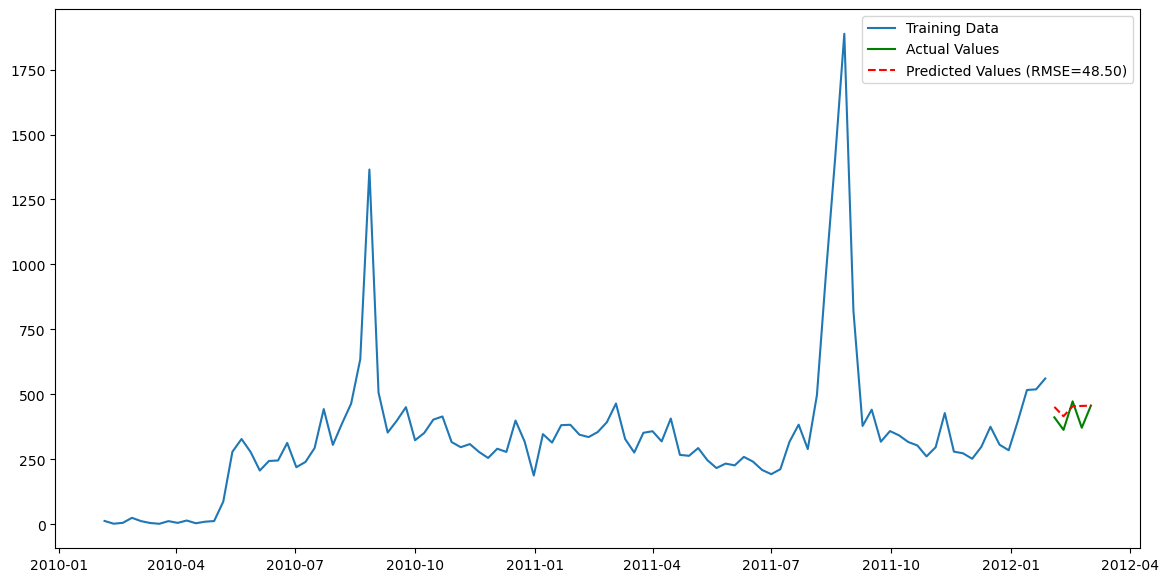

In [94]:
# plot for one store one Dept
plot_train = train_df[(train_df["Store"]==36)&(train_df["Dept"]==3)]
plot_test = merged_data[(merged_data["Store"]==36)&(merged_data["Dept"]==3)]
# y_pred = all_forecasts[(all_forecasts["Store"]==1)&(all_forecasts["Dept"]==1)]
rmse = np.sqrt(mean_squared_error(plot_test.y, plot_test.yhat))

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(plot_train.ds, plot_train.y, label='Training Data')
plt.plot(plot_test.ds, plot_test.y, label='Actual Values', color='green')
plt.plot(plot_test.ds, plot_test.yhat, label='Predicted Values (RMSE={:0.2f})'.format(rmse), linestyle='--', color='red')
plt.legend()
plt.show()

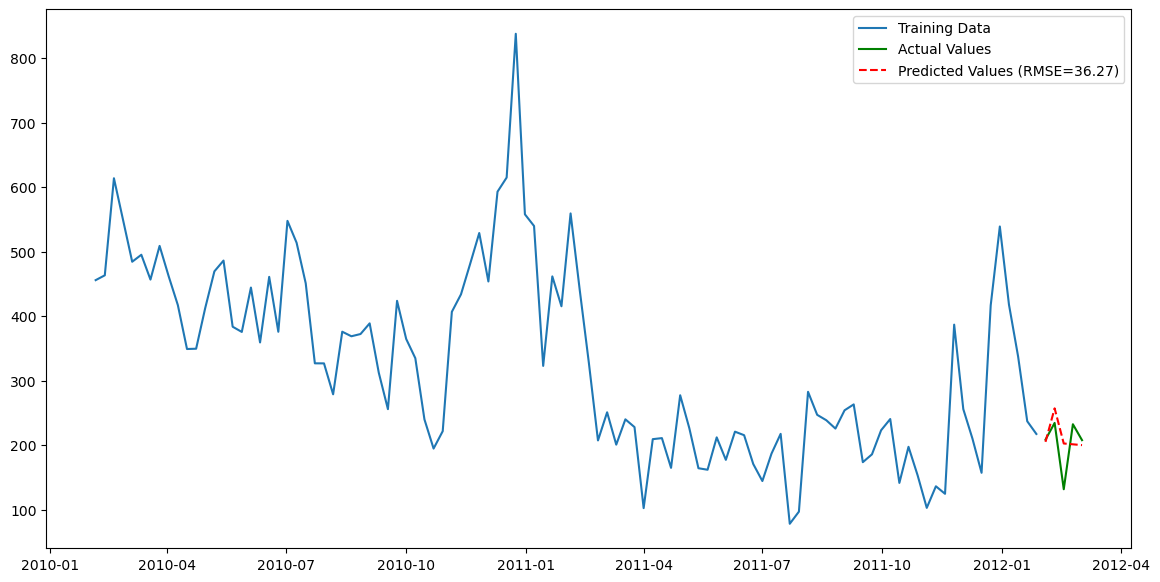

In [95]:
# plot for one store one Dept
plot_train = train_df[(train_df["Store"]==25)&(train_df["Dept"]==83)]
plot_test = merged_data[(merged_data["Store"]==25)&(merged_data["Dept"]==83)]
# y_pred = all_forecasts[(all_forecasts["Store"]==1)&(all_forecasts["Dept"]==1)]
rmse = np.sqrt(mean_squared_error(plot_test.y, plot_test.yhat))

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(plot_train.ds, plot_train.y, label='Training Data')
plt.plot(plot_test.ds, plot_test.y, label='Actual Values', color='green')
plt.plot(plot_test.ds, plot_test.yhat, label='Predicted Values (RMSE={:0.2f})'.format(rmse), linestyle='--', color='red')
plt.legend()
plt.show()